In [455]:
from os import listdir
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

warnings.filterwarnings(action='ignore')

plt.style.use('ggplot') #ggplot스타일 사용
plt.rc('axes', unicode_minus=False)

In [456]:
model_path = './modeling_folder'
data_file_path = './open data'

In [568]:
# modeling_file_ls = []
# for file in os.listdir(model_path):
#     if 'modeling' in file:
#         modeling_file_ls.append(file)

# ver_num_ls = []
# for file in modeling_file_ls:
#     ver_num_ls.append(re.sub('[^0-9]','',file))

# ver_num = int(pd.Series(list(set(ver_num_ls))).sort_values(ascending=False).iloc[0])
ver_num =  1

base_tr = pd.read_csv(os.path.join(data_file_path,'train.csv'))
tr = pd.read_csv(
    os.path.join(model_path,'modeling_tr_ver{}.csv'.format(ver_num))
)
te = pd.read_csv(
    os.path.join(model_path,'modeling_te_ver{}.csv'.format(ver_num))
)

base_column = base_tr.drop(columns = 'index').columns.tolist()
submission = te[['index']]

tr.drop(columns = 'index',inplace = True)
te.drop(columns = 'index', inplace = True)

In [553]:
tr.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'voted', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13',
       'Q_E_sum', 'Q_E_median', 'education_ft1', 'education_ft2',
       'married_value', 'age_group_value', 'wr_sum', 'wf_sum', 'wr_wf_sum'],
      dtype='object')

In [561]:
for col in ['age_group', 'education', 'engnat', 'familysize', 'gender', 'hand','married', 'race', 'religion','urban']:
    tr[col] = tr[col].astype('category')

for col in ['age_group', 'education', 'engnat', 'familysize', 'gender', 'hand','married', 'race', 'religion','urban']:
    te[col] = te[col].astype('category')

# Model training

## LGBM Modeling code

In [559]:
def validation_model(df,base_column):
    plus_col = list(set(df.columns.tolist()) - set(base_column))
    except_col = list(set(base_column) - set(df.columns.tolist()))
    print(f'추가변수 : {plus_col}')
    print(f'제외변수 : {except_col}')
    X_train, X_test, y_train, y_test = train_test_split(
                                df.drop(columns = 'voted'),df['voted'],
                                random_state = 0,
                                test_size = 0.2
                            )
    
    folds = StratifiedKFold(n_splits=5, shuffle = True, random_state = 111)
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    feature_importance = pd.DataFrame()
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):
        
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = lgb.LGBMClassifier(
            n_estimators=1000,
            objective='binary',
            boosting_type='gbdt',
            bagging_fraction = 0.9515683153667026,
            colsample_bytree = 0.7860120233288207,
            feature_fraction = 0.9362075859090412,
            lambda_l1 = 0.7111030183072032,
            lambda_l2 = 0.5642765168754059,
            learning_rate = 0.011407920284082697,
            max_depth = 6,
            min_child_weight = 33,
            num_leaves = 380,
            random_state= 200,
        )
        
        clf.fit(
            train_x, train_y,
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', 
            verbose= 100, 
            early_stopping_rounds=300,
        )
        
        oof_preds[valid_idx] = clf.predict_proba(valid_x, best_iteration_ = clf.best_iteration_)[:,1]
        test_preds += clf.predict_proba(X_test, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits 
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    
    ft = feature_importance.groupby('feature')['importance'].mean().reset_index()

    ft2 = ft.sort_values('importance',ascending = False).iloc[:50]
    
    feature_graph_df = feature_importance.sort_values('importance')
    plt.figure(figsize = (16,12))
    plt.barh(ft2['feature'],ft2['importance'])
    
    final_score = roc_auc_score(y_test,test_preds)
    print('\n\n')
    print('================================================')
    print(f'\n최종성능: {final_score}\n')
    print('================================================')
    return ft, test_preds, y_test

### LGBM training

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781267	training's binary_logloss: 0.575011	valid_1's auc: 0.761699	valid_1's binary_logloss: 0.583947
[200]	training's auc: 0.789501	training's binary_logloss: 0.549447	valid_1's auc: 0.763254	valid_1's binary_logloss: 0.564458
[300]	training's auc: 0.79773	training's binary_logloss: 0.538394	valid_1's auc: 0.764041	valid_1's binary_logloss: 0.559624
[400]	training's auc: 0.807435	training's binary_logloss: 0.529691	valid_1's auc: 0.764373	valid_1's binary_logloss: 0.558538
[500]	training's auc: 0.81612	training's binary_logloss: 0.522137	valid_1's auc: 0.765176	valid_1's binary_logloss: 0.558025
[600]	training's auc: 0.823739	training's binary_logloss: 0.515598	valid_1's auc: 0.765334	valid_1's binary_logloss: 0.558031
[700]	training's auc: 0.830657	trainin

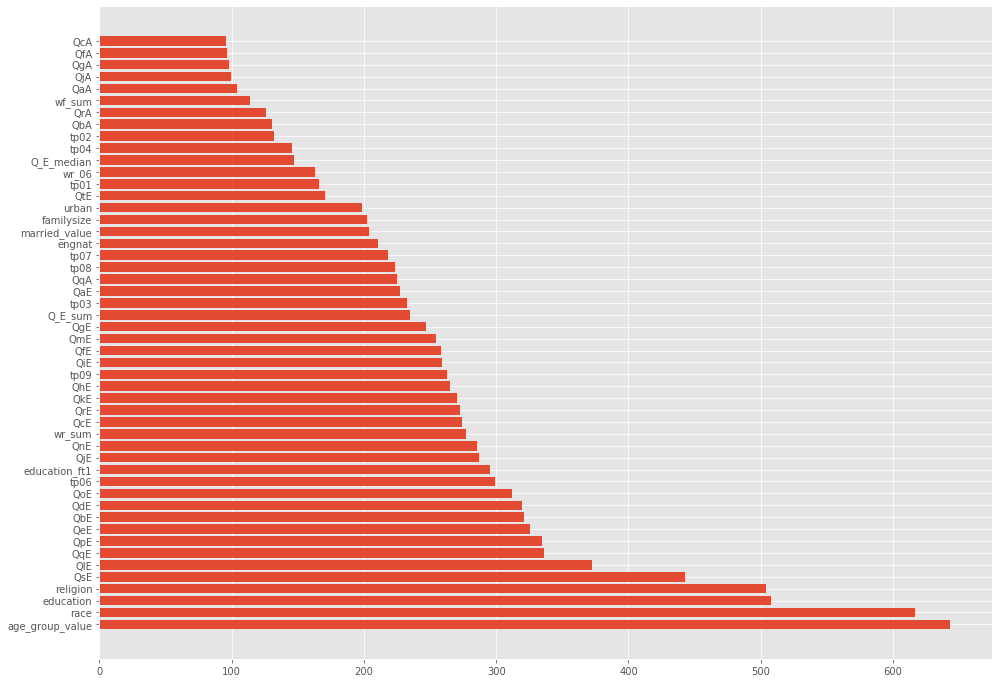

In [52]:
# random_state = 0 - > 0.7802
# random_state: 200 -> 0.7807 -> 오케이!
# ver1 kfold random_state최적화 안했을 때의 성능이 가장 높았음...
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['QlAnon_voted_value', 'QpAnon_voted_value', 'QkAnon_voted_value', 'QcAnon_voted_value', 'QjAnon_voted_value', 'QmAnon_voted_value', 'education_ft1', 'Q_E_sum', 'QoAnon_voted_value', 'QtAnon_voted_value', 'education_ft2', 'QrAnon_voted_value', 'wr_wf_sum', 'QeAnon_voted_value', 'QiAnon_voted_value', 'QhAnon_voted_value', 'QdAnon_voted_value', 'QgAnon_voted_value', 'QnAnon_voted_value', 'married_value', 'QsAnon_voted_value', 'QfAnon_voted_value', 'Q_E_median', 'QqAnon_voted_value', 'QaAnon_voted_value', 'age_group_value', 'wr_sum', 'QbAnon_voted_value', 'wf_sum']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.780069	training's binary_logloss: 0.575918	valid_1's auc: 0.762678	valid_1's binary_logloss: 0.580396
[200]	training's auc: 0.789341	training's binary_logloss: 0.549935	valid_1's auc: 0.765016	valid_1's binary_logloss: 0.560491
[300]	training's auc: 0.797014	training's binary_logloss: 0.539165	valid_1's auc: 0.765614	valid_1's

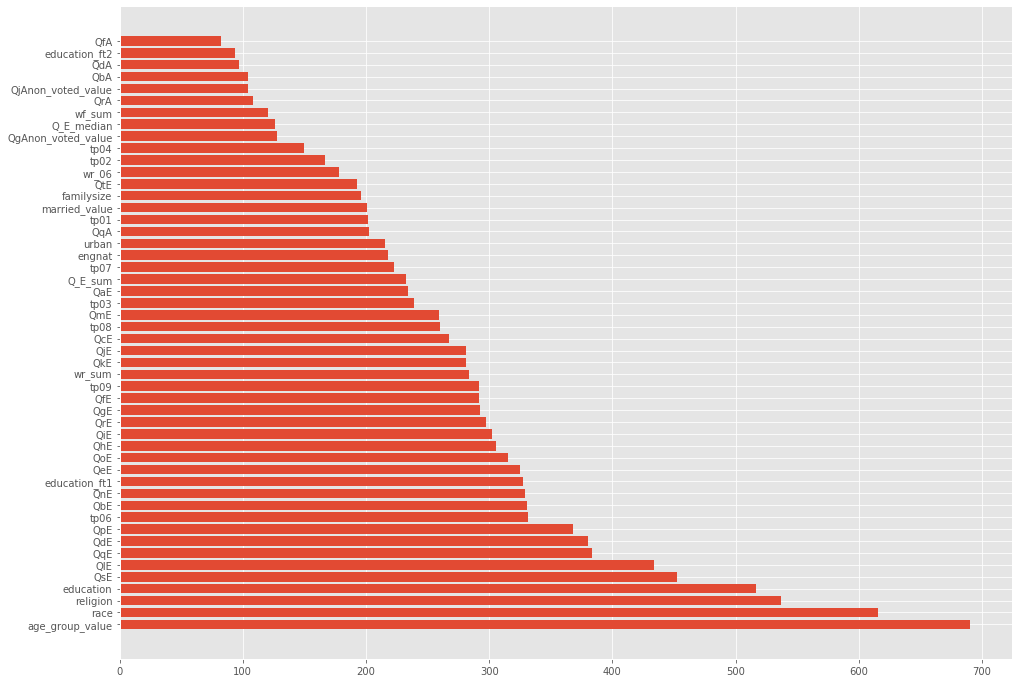

In [68]:
# ver2
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['QlAnon_voted_value', 'QpAnon_voted_value', 'QkAnon_voted_value', 'QcAnon_voted_value', 'QjAnon_voted_value', 'QmAnon_voted_value', 'education_ft1', 'Q_E_sum', 'QoAnon_voted_value', 'QtAnon_voted_value', 'education_ft2', 'QrAnon_voted_value', 'wr_wf_sum', 'QeAnon_voted_value', 'QiAnon_voted_value', 'QhAnon_voted_value', 'QdAnon_voted_value', 'QgAnon_voted_value', 'QnAnon_voted_value', 'married_value', 'QsAnon_voted_value', 'QfAnon_voted_value', 'Q_E_median', 'index', 'QqAnon_voted_value', 'QaAnon_voted_value', 'age_group_value', 'wr_sum', 'QbAnon_voted_value', 'wf_sum']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781476	training's binary_logloss: 0.574622	valid_1's auc: 0.757034	valid_1's binary_logloss: 0.584405
[200]	training's auc: 0.790953	training's binary_logloss: 0.548351	valid_1's auc: 0.76051	valid_1's binary_logloss: 0.565538
[300]	training's auc: 0.799221	training's binary_logloss: 0.537377	valid_1's auc: 0.761945	v

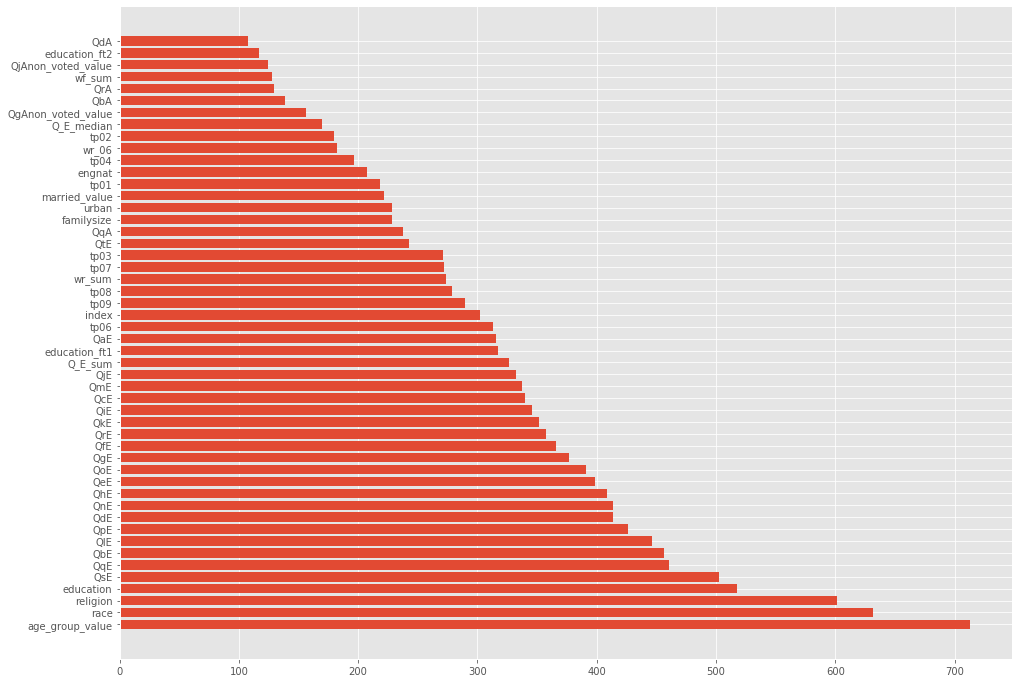

In [74]:
# ver3
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['QlAnon_voted_value', 'QpAnon_voted_value', 'QkAnon_voted_value', 'QcAnon_voted_value', 'QjAnon_voted_value', 'QmAnon_voted_value', 'education_ft1', 'Q_E_sum', 'QoAnon_voted_value', 'QtAnon_voted_value', 'education_ft2', 'QrAnon_voted_value', 'wr_wf_sum', 'QeAnon_voted_value', 'QiAnon_voted_value', 'QhAnon_voted_value', 'QdAnon_voted_value', 'QgAnon_voted_value', 'QnAnon_voted_value', 'married_value', 'QsAnon_voted_value', 'QfAnon_voted_value', 'Q_E_median', 'index', 'QqAnon_voted_value', 'QaAnon_voted_value', 'age_group_value', 'wr_sum', 'QbAnon_voted_value', 'wf_sum']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.7811	training's binary_logloss: 0.575334	valid_1's auc: 0.762971	valid_1's binary_logloss: 0.582478
[200]	training's auc: 0.789869	training's binary_logloss: 0.549346	valid_1's auc: 0.764594	valid_1's binary_logloss: 0.563588
[300]	training's auc: 0.798312	training's binary_logloss: 0.538017	valid_1's auc: 0.766048	va

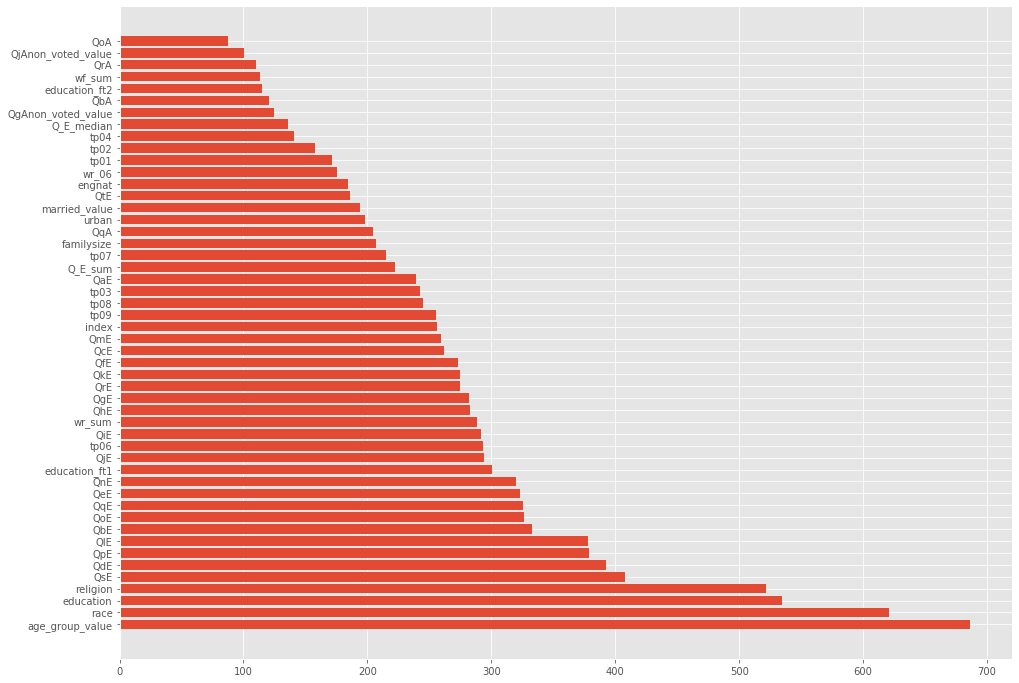

In [85]:
# ver3 -> 실수
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['QlAnon_voted_value', 'QpAnon_voted_value', 'QkAnon_voted_value', 'QcAnon_voted_value', 'QjAnon_voted_value', 'QmAnon_voted_value', 'education_ft1', 'Q_E_sum', 'QoAnon_voted_value', 'QtAnon_voted_value', 'education_ft2', 'QrAnon_voted_value', 'wr_wf_sum', 'QeAnon_voted_value', 'QiAnon_voted_value', 'QhAnon_voted_value', 'QdAnon_voted_value', 'QgAnon_voted_value', 'QnAnon_voted_value', 'married_value', 'QsAnon_voted_value', 'QfAnon_voted_value', 'Q_E_median', 'index', 'QqAnon_voted_value', 'QaAnon_voted_value', 'age_group_value', 'wr_sum', 'QbAnon_voted_value', 'wf_sum']
제외변수 : ['QaA', 'QgA', 'QpA', 'QmA', 'QtA', 'QjA', 'QsA', 'QoA', 'QnA', 'QfA', 'QiA', 'QcA', 'QqA', 'QeA', 'QrA', 'QbA', 'QhA', 'QlA', 'QdA', 'QkA']
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.782493	training's binary_logloss: 0.574323	valid_1's auc: 0.761883	valid_1's binary_logloss: 0.584782
[200]	training's auc: 0.791852	training's binary_logloss: 0.547828	valid_1's au

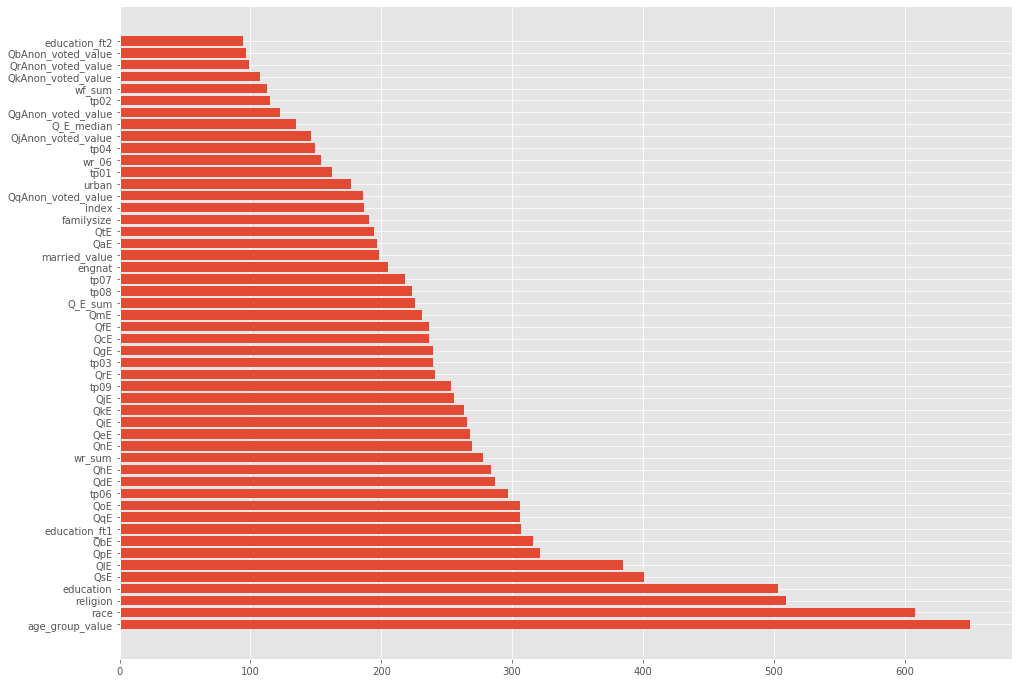

In [100]:
# ver4 -> 제출 0.77대
# fold_random_state = 1001
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779375	training's binary_logloss: 0.575731	valid_1's auc: 0.766828	valid_1's binary_logloss: 0.580464
[200]	training's auc: 0.788559	training's binary_logloss: 0.550048	valid_1's auc: 0.770065	valid_1's binary_logloss: 0.560253
[300]	training's auc: 0.797776	training's binary_logloss: 0.538659	valid_1's auc: 0.772079	valid_1's binary_logloss: 0.555398
[400]	training's auc: 0.809041	training's binary_logloss: 0.529048	valid_1's auc: 0.773068	valid_1's binary_logloss: 0.553965
[500]	training's auc: 0.819096	training's binary_logloss: 0.520857	valid_1's auc: 0.773047	valid_1's binary_logloss: 0.553749
[600]	training's auc: 0.827015	training's binary_logloss: 0.514272	valid_1's auc: 0.773172	valid_1's binary_logloss: 0.553541
[700]	training's auc: 0.833

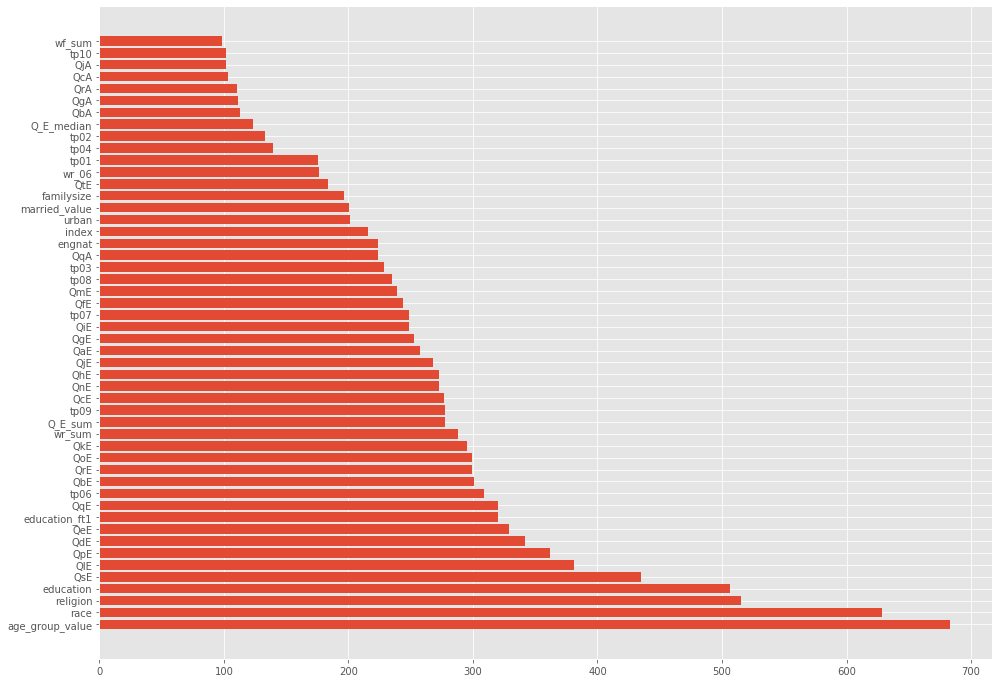

In [206]:
# 다시 ver1 -> 0.7802
# random_state 완전 세팅해서 341로 세팅
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'education_ft2', 'Q_E_max', 'Q_E_min', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'age_mar_index', 'Q_E_std', 'Q_E_sum', 'rac_rel_index', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.780119	training's binary_logloss: 0.574852	valid_1's auc: 0.765538	valid_1's binary_logloss: 0.580553
[200]	training's auc: 0.788491	training's binary_logloss: 0.549196	valid_1's auc: 0.768369	valid_1's binary_logloss: 0.561026
[300]	training's auc: 0.797993	training's binary_logloss: 0.537932	valid_1's auc: 0.770423	valid_1's binary_logloss: 0.556328
[400]	training's auc: 0.809541	training's binary_logloss: 0.528344	valid_1's auc: 0.771446	valid_1's binary_logloss: 0.554984
[500]	training's auc: 0.819632	training's binary_logloss: 0.520004	valid_1's auc: 0.771402	valid_1's binary_logloss: 0.554728
[600]	training's auc: 0.828641	training's binary_logloss: 0.512653	valid_1's auc: 0.77

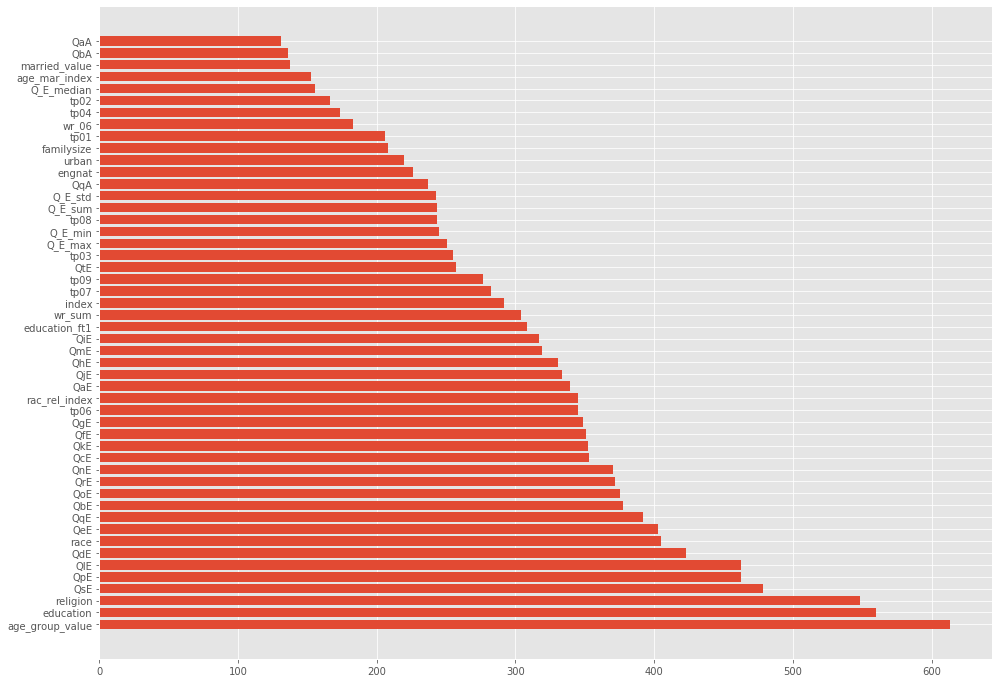

In [222]:
# ver5 -> 0.7788
# 카테고리 교호변수 + Q_E 통계값 추가
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'education_ft2', 'Q_E_min', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'rac_rel_index', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.778777	training's binary_logloss: 0.575362	valid_1's auc: 0.764673	valid_1's binary_logloss: 0.580853
[200]	training's auc: 0.788225	training's binary_logloss: 0.549505	valid_1's auc: 0.768605	valid_1's binary_logloss: 0.560966
[300]	training's auc: 0.797213	training's binary_logloss: 0.538386	valid_1's auc: 0.770261	valid_1's binary_logloss: 0.556446
[400]	training's auc: 0.808222	training's binary_logloss: 0.529115	valid_1's auc: 0.771165	valid_1's binary_logloss: 0.555144
[500]	training's auc: 0.818095	training's binary_logloss: 0.521032	valid_1's auc: 0.770993	valid_1's binary_logloss: 0.554933
[600]	training's auc: 0.827027	training's binary_logloss: 0.513693	valid_1's auc: 0.770989	valid_1's binary_logloss: 0.55484


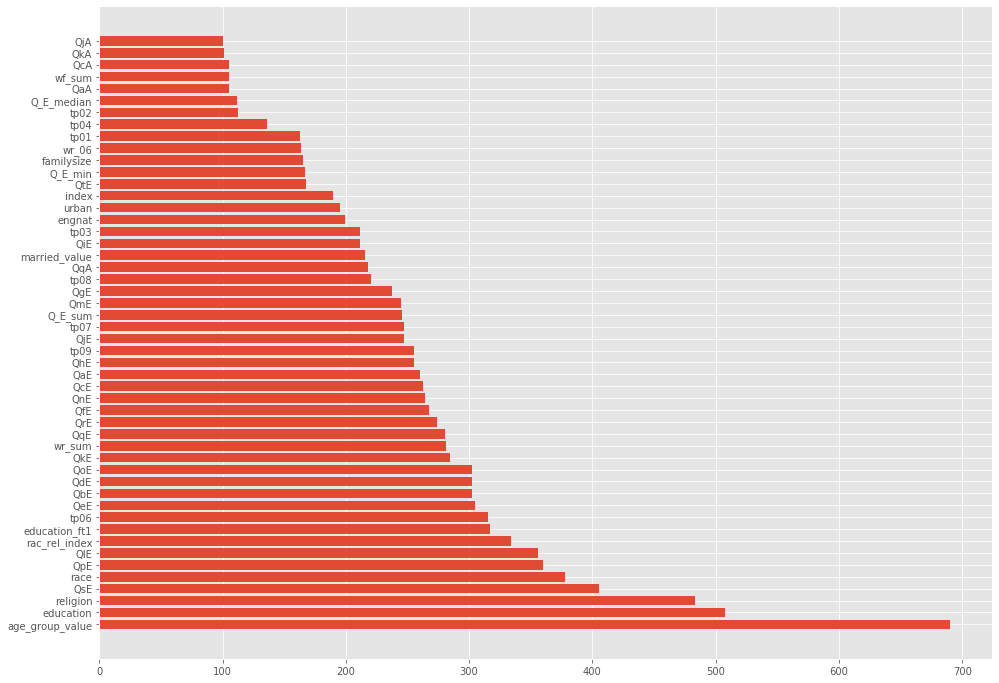

In [232]:
# ver5 -> 안봐도 성능 비디오
# 카테고리 교호변수 + Q_E 통계값 추가 - 상관계수 높은 변수 제거
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'tp03_category', 'education_ft2', 'age_group_value', 'wr_sum', 'tp08_category', 'tp07_category', 'tp02_category', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'tp04_category', 'tp09_category', 'tp06_category', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779808	training's binary_logloss: 0.575667	valid_1's auc: 0.767217	valid_1's binary_logloss: 0.580449
[200]	training's auc: 0.788867	training's binary_logloss: 0.549855	valid_1's auc: 0.770146	valid_1's binary_logloss: 0.560195
[300]	training's auc: 0.797753	training's binary_logloss: 0.538673	valid_1's auc: 0.771604	valid_1's binary_logloss: 0.555602
[400]	training's auc: 0.809543	training's binary_logloss: 0.528695	valid_1's auc: 0.772742	valid_1's binary_logloss: 0.554088
[500]	training's auc: 0.818623	training's binary_logloss: 0.521057	valid_1's auc: 0.772425	valid_1's binary_logloss: 0.553948
[600]	training's auc: 0.826776	tra

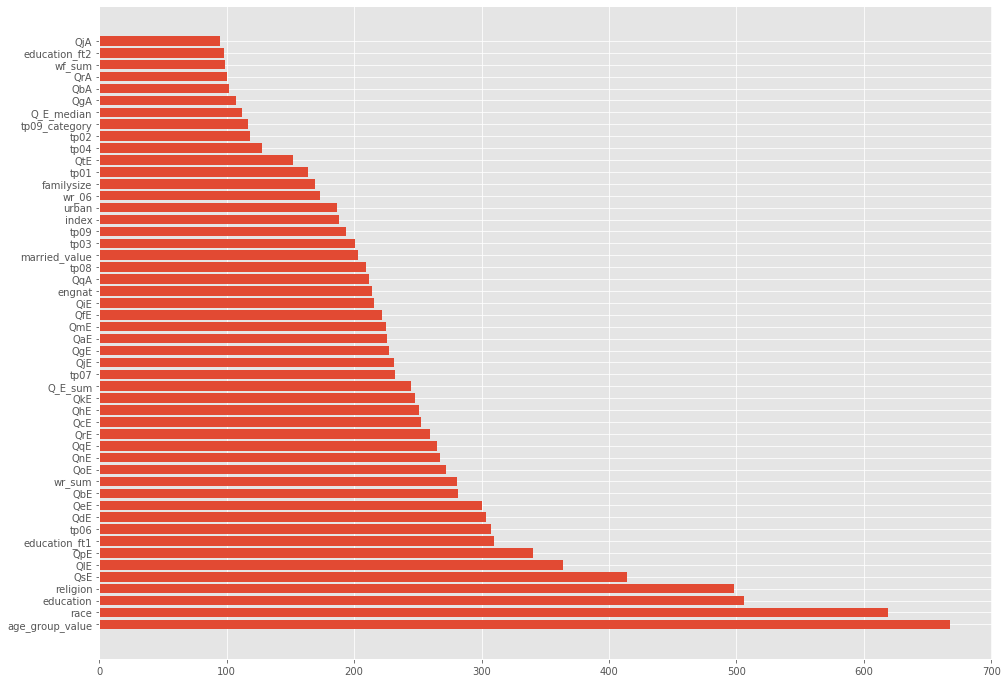

In [235]:
# ver6 -> 78023
# 카테고리 교호변수 + Q_E 통계값 추가 -> 다빼고  + tp 분포도 통계만
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'tp03_category', 'education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'tp09_category', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.780402	training's binary_logloss: 0.575588	valid_1's auc: 0.766827	valid_1's binary_logloss: 0.580621
[200]	training's auc: 0.78874	training's binary_logloss: 0.549879	valid_1's auc: 0.76991	valid_1's binary_logloss: 0.560433
[300]	training's auc: 0.797773	training's binary_logloss: 0.53861	valid_1's auc: 0.771812	valid_1's binary_logloss: 0.555581
[400]	training's auc: 0.809025	training's binary_logloss: 0.529035	valid_1's auc: 0.772811	valid_1's binary_logloss: 0.554121
[500]	training's auc: 0.818938	training's binary_logloss: 0.520984	valid_1's auc: 0.772654	valid_1's binary_logloss: 0.553907
[600]	training's auc: 0.827549	training's binary_logloss: 0.513872	valid_1's auc: 0.773035	valid_1's binary_logloss: 0.553

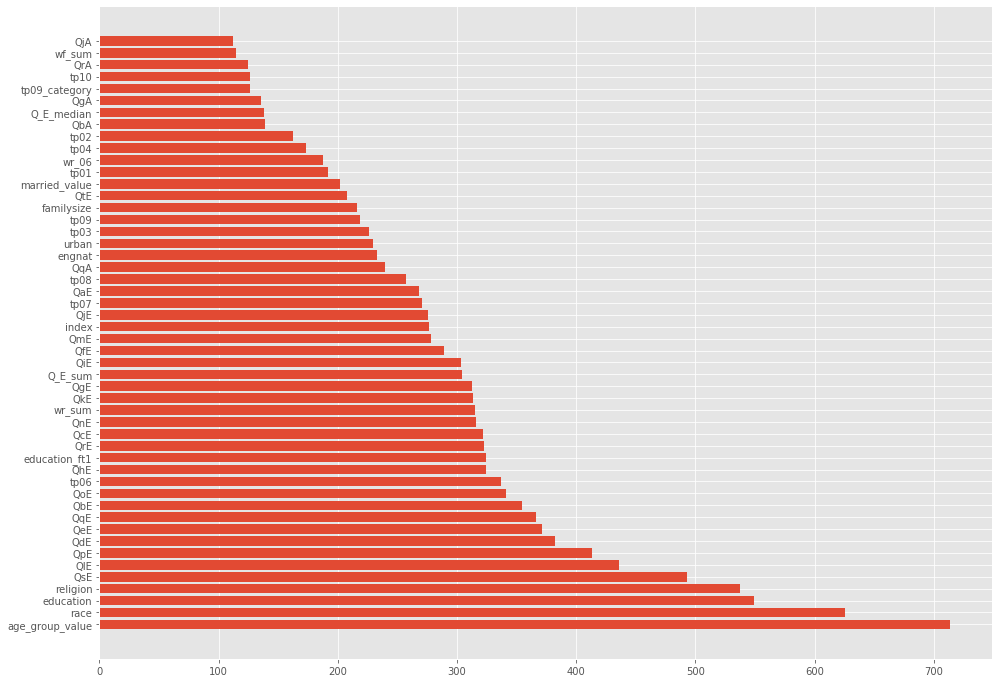

In [244]:
# ver6 -> 0.78
# 카테고리 교호변수 + Q_E 통계값 추가 -> 다빼고  + tp 분포도 통계만
# ver6는 절대 하지 않기로
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'tp03_category', 'education_ft2', 'Q_E_min', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'tp09_category', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.780414	training's binary_logloss: 0.575605	valid_1's auc: 0.76722	valid_1's binary_logloss: 0.580551
[200]	training's auc: 0.789653	training's binary_logloss: 0.549422	valid_1's auc: 0.770105	valid_1's binary_logloss: 0.560409
[300]	training's auc: 0.798433	training's binary_logloss: 0.538166	valid_1's auc: 0.771876	valid_1's binary_logloss: 0.555603
[400]	training's auc: 0.809204	training's binary_logloss: 0.528889	valid_1's auc: 0.772256	valid_1's binary_logloss: 0.554409
[500]	training's auc: 0.818948	training's binary_logloss: 0.520968	valid_1's auc: 0.772156	valid_1's binary_logloss: 0.554188
[600]	training's auc: 0.827798	training's binary_logloss: 0.513689	valid_1's auc: 0.772523	valid_1's binary_l

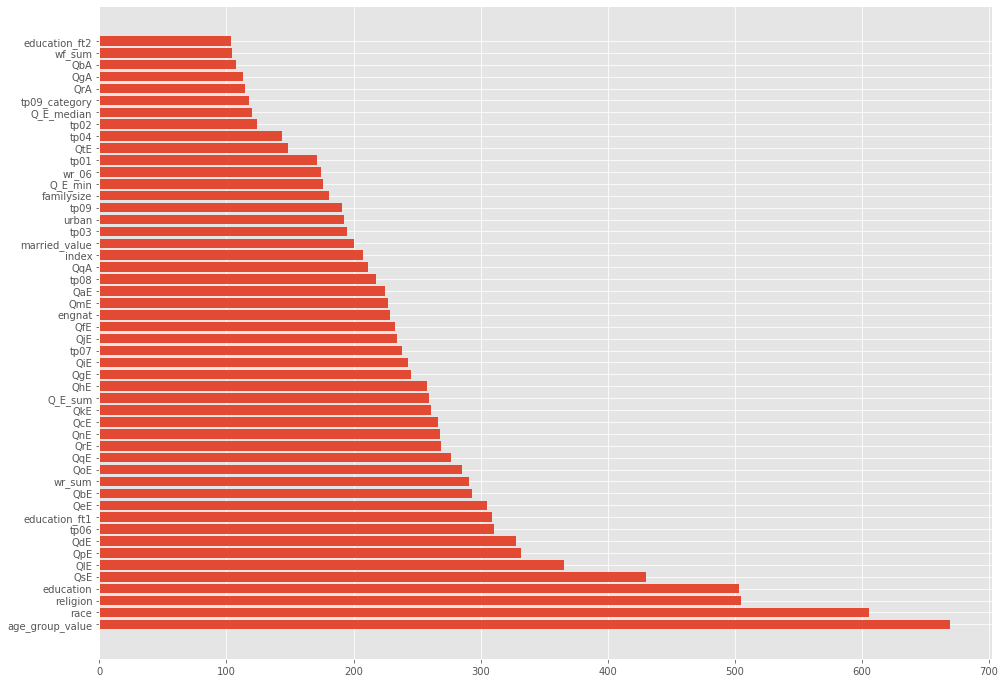

In [256]:
# ver6 -> Min만 넣어서
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['tp03_category', 'education_ft2', 'Q_E_min', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'tp09_category', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.780255	training's binary_logloss: 0.575659	valid_1's auc: 0.767082	valid_1's binary_logloss: 0.580605
[200]	training's auc: 0.788617	training's binary_logloss: 0.5499	valid_1's auc: 0.769955	valid_1's binary_logloss: 0.560446
[300]	training's auc: 0.797629	training's binary_logloss: 0.53865	valid_1's auc: 0.771882	valid_1's binary_logloss: 0.555601
[400]	training's auc: 0.808702	training's binary_logloss: 0.529215	valid_1's auc: 0.772544	valid_1's binary_logloss: 0.554214
[500]	training's auc: 0.818601	training's binary_logloss: 0.521159	valid_1's auc: 0.772435	valid_1's binary_logloss: 0.553959
[600]	training's auc: 0.827178	training's binary_logloss: 0.514144	valid_1's auc: 0.772478	valid_1's binary_logloss: 0.5

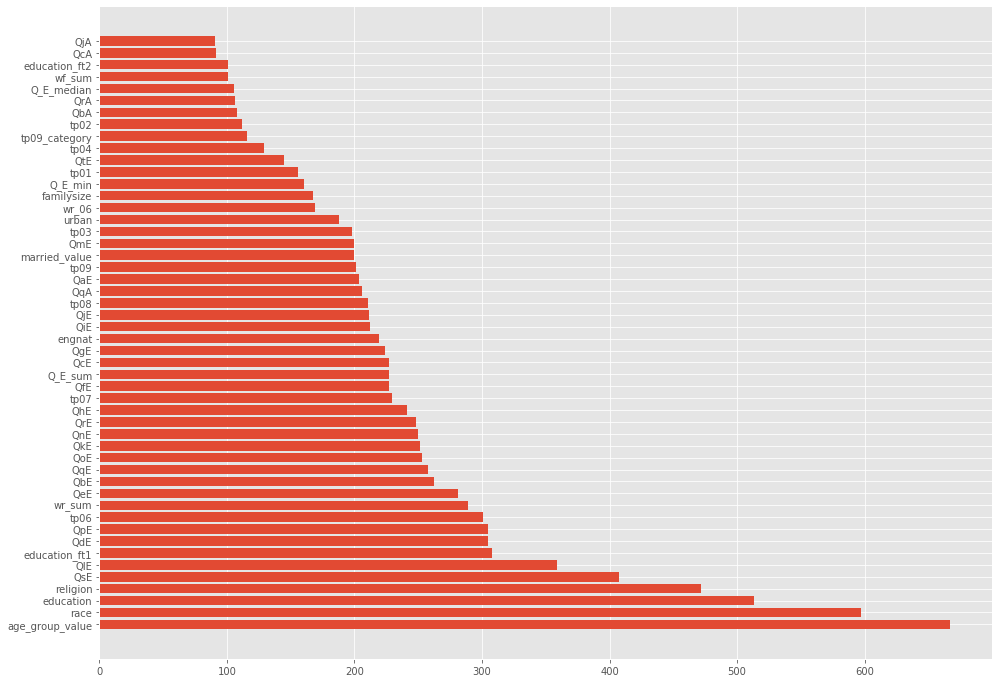

In [258]:
# ver6 -> Min만 넣어서
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779602	training's binary_logloss: 0.575679	valid_1's auc: 0.76704	valid_1's binary_logloss: 0.580424
[200]	training's auc: 0.788628	training's binary_logloss: 0.549932	valid_1's auc: 0.770287	valid_1's binary_logloss: 0.560184
[300]	training's auc: 0.797573	training's binary_logloss: 0.538667	valid_1's auc: 0.772311	valid_1's binary_logloss: 0.555303
[400]	training's auc: 0.808999	training's binary_logloss: 0.529	valid_1's auc: 0.773485	valid_1's binary_logloss: 0.553706
[500]	training's auc: 0.819062	training's binary_logloss: 0.520758	valid_1's auc: 0.773582	valid_1's binary_logloss: 0.553422
[600]	training's auc: 0.827175	training's binary_logloss: 0.514052	valid_1's auc: 0.773535	valid_1's binary_logloss: 0.553361
[700]	training's auc: 0.83371	training's

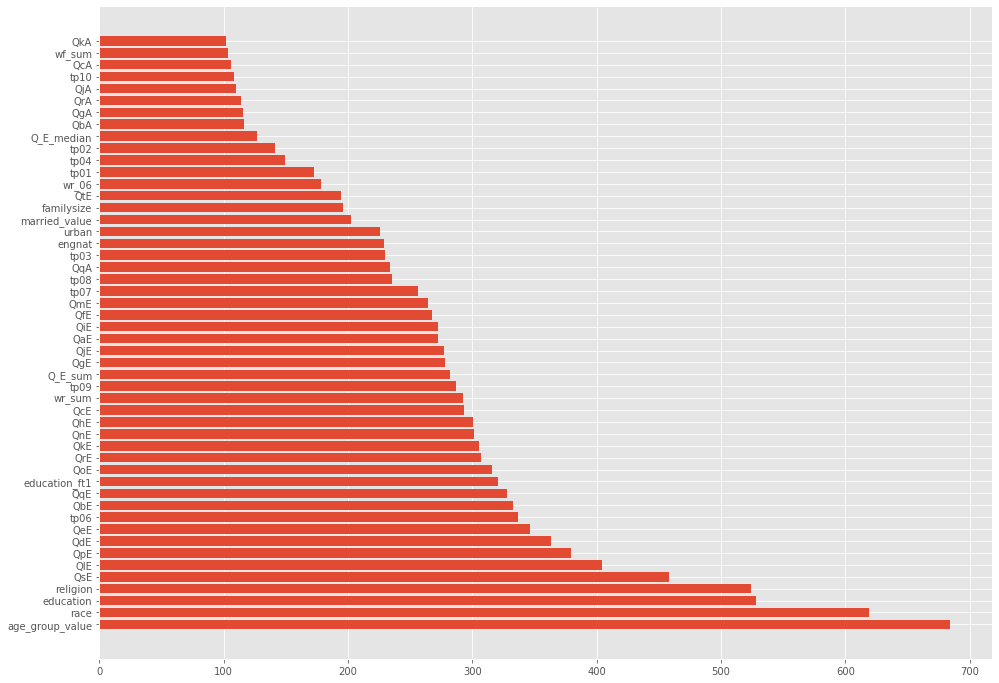

In [262]:
# ver1 다시 수행
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['index', 'education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'Mach_score', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781118	training's binary_logloss: 0.575442	valid_1's auc: 0.76545	valid_1's binary_logloss: 0.581383
[200]	training's auc: 0.79033	training's binary_logloss: 0.549696	valid_1's auc: 0.767689	valid_1's binary_logloss: 0.562518
[300]	training's auc: 0.798746	training's binary_logloss: 0.538744	valid_1's auc: 0.769413	valid_1's binary_logloss: 0.557778
[400]	training's auc: 0.808258	training's binary_logloss: 0.530345	valid_1's auc: 0.76953	valid_1's binary_logloss: 0.556917
[500]	training's auc: 0.817652	training's binary_logloss: 0.522546	valid_1's auc: 0.769553	valid_1's binary_logloss: 0.556569
[600]	training's auc: 0.825277	training's binary_logloss: 0.516045	valid_1's auc: 0.769821	valid_1's binary_logloss: 0.556318
[700]	training's

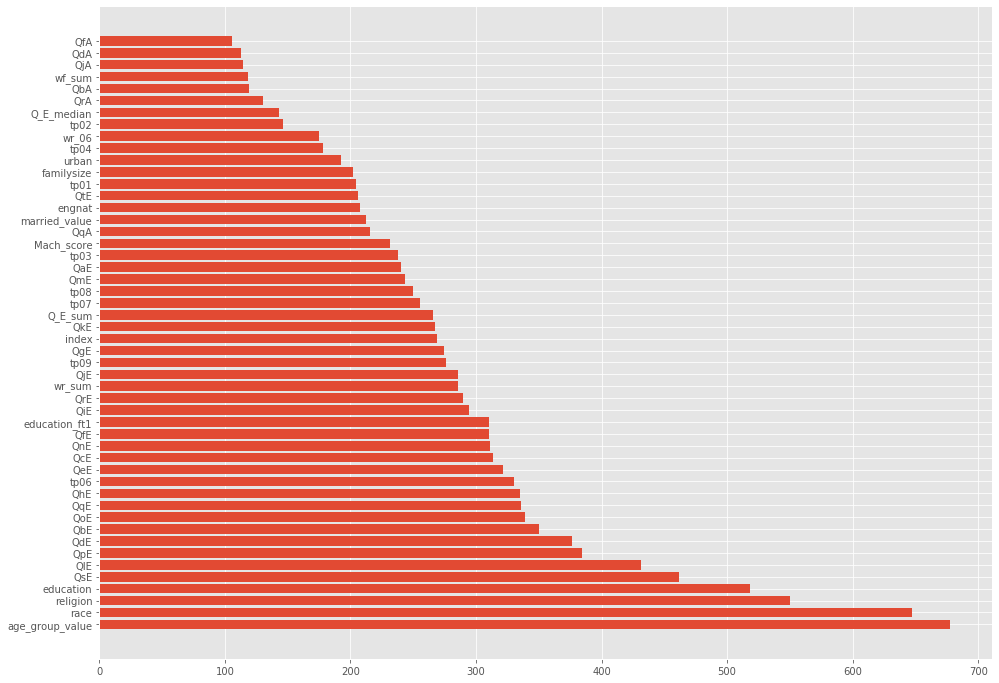

In [293]:
# ver7
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.78081	training's binary_logloss: 0.575508	valid_1's auc: 0.765383	valid_1's binary_logloss: 0.581336
[200]	training's auc: 0.79019	training's binary_logloss: 0.549773	valid_1's auc: 0.76767	valid_1's binary_logloss: 0.562454
[300]	training's auc: 0.798635	training's binary_logloss: 0.538775	valid_1's auc: 0.769543	valid_1's binary_logloss: 0.557764
[400]	training's auc: 0.808269	training's binary_logloss: 0.530317	valid_1's auc: 0.769914	valid_1's binary_logloss: 0.556768
[500]	training's auc: 0.81797	training's binary_logloss: 0.522364	valid_1's auc: 0.769967	valid_1's binary_logloss: 0.55644
[600]	training's auc: 0.825933	training's binary_logloss: 0.515552	valid_1's auc: 0.76979	valid_1's binary_logloss: 0.556445
[700]	training's auc: 0.832935	training's 

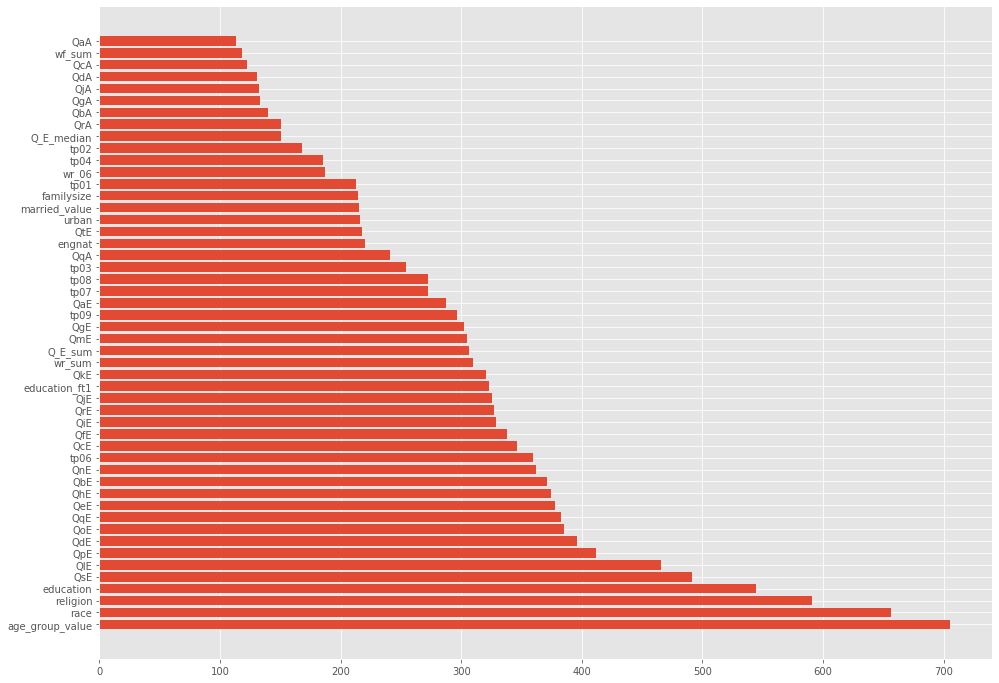

In [410]:
# ver1 -> 
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['QrE_log', 'QeE_log', 'QmE_log', 'QiE_log', 'QkE_log', 'education_ft1', 'Q_E_sum', 'QgE_log', 'QlE_log', 'QnE_log', 'QjE_log', 'education_ft2', 'wr_wf_mul', 'QdE_log', 'wr_wf_diff', 'wr_wf_sum', 'tp_mean', 'QhE_log', 'married_value', 'QsE_log', 'wf_wf_sum', 'Mach_score', 'QqE_log', 'Q_E_median', 'age_group_value', 'wr_wr_sum', 'wr_sum', 'QcE_log', 'QfE_log', 'QpE_log', 'QaE_log', 'QtE_log', 'tp_median', 'QoE_log', 'wf_sum', 'QbE_log']
제외변수 : ['QqE', 'QnE', 'QcE', 'QrE', 'QkE', 'QaE', 'QgE', 'QpE', 'QhE', 'QdE', 'QsE', 'QtE', 'QoE', 'QiE', 'QmE', 'QfE', 'QjE', 'QeE', 'QbE', 'QlE']
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781926	training's binary_logloss: 0.575391	valid_1's auc: 0.765991	valid_1's binary_logloss: 0.58139
[200]	training's auc: 0.790816	training's binary_logloss: 0.549431	valid_1's auc: 0.768118	valid_1's binary_logloss: 0.562204
[300]	training's auc: 0.798576	training's binary_logloss: 0.53866	valid_1's auc: 0.769302	va

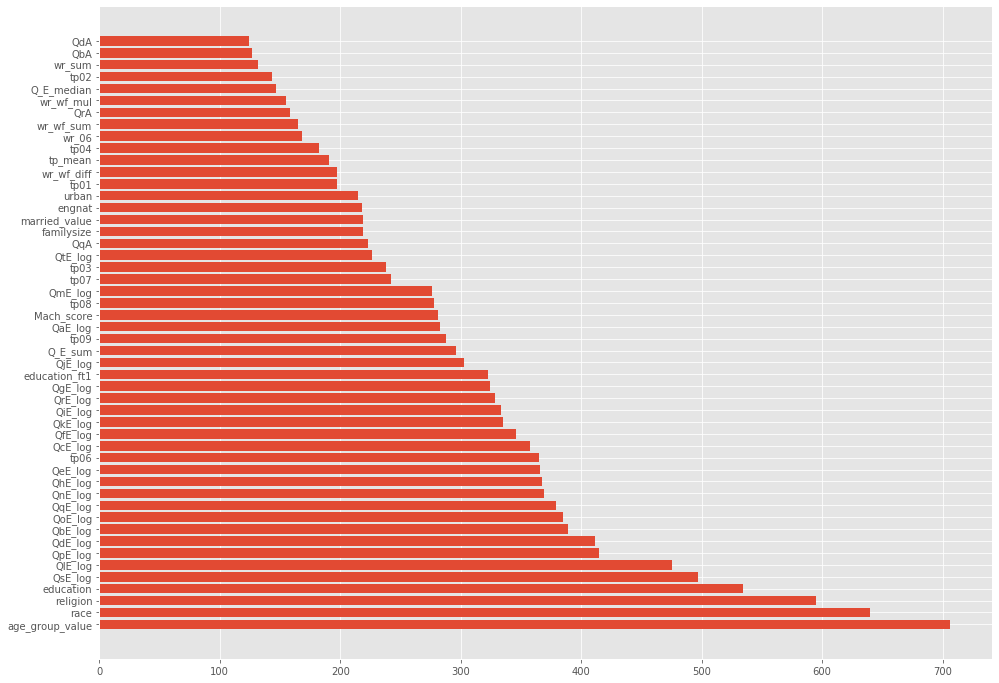

In [417]:
# ver10 -> 
ft, test_preds, y_test = validation_model(tr,base_column)

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.78289	training's binary_logloss: 0.574109	valid_1's auc: 0.764767	valid_1's binary_logloss: 0.580744
[200]	training's auc: 0.792487	training's binary_logloss: 0.547565	valid_1's auc: 0.768189	valid_1's binary_logloss: 0.561352
[300]	training's auc: 0.801067	training's binary_logloss: 0.53629	valid_1's auc: 0.769862	valid_1's binary_logloss: 0.556635
[400]	training's auc: 0.810524	training's binary_logloss: 0.527509	valid_1's auc: 0.770975	valid_1's binary_logloss: 0.554996
[500]	training's auc: 0.820598	training's binary_logloss: 0.519245	valid_1's auc: 0.770863	valid_1's binary_logloss: 0.554851
[600]	training's auc: 0.828807	training's binary_logloss: 0.512388	valid_1's auc: 0.770622	valid_1's binary_logloss: 0.555016
[700]	training's auc: 0.836383	trainin

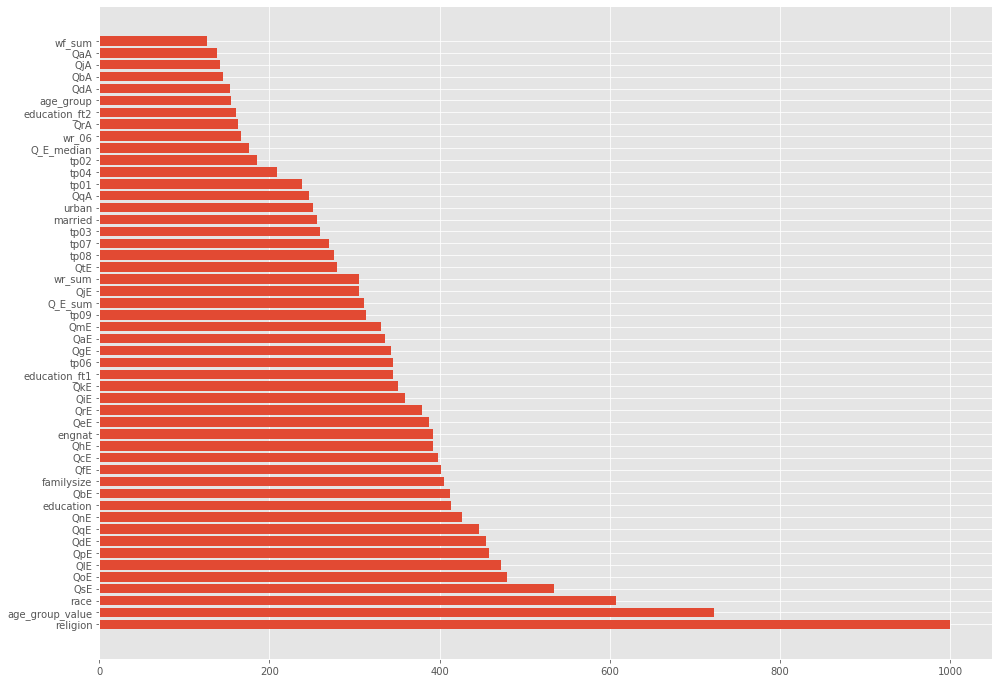

In [562]:
ft, test_preds, y_test = validation_model(tr,base_column)

#### LGBM CV

In [465]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [543]:
#tr2 = tr.select_dtypes('int64')
tr2 = tr[['QaE','QbE']]

In [544]:
X_train, X_test, y_train, y_test = train_test_split(
                                tr2,tr['voted'],
                                random_state = 0,
                                test_size = 0.2
                            )

# X_train, X_test, y_train, y_test = train_test_split(
#                                 tr2.drop(columns = 'voted'),tr['voted'],
#                                 random_state = 0,
#                                 test_size = 0.2
#                             )

In [532]:
clf = lgb.LGBMClassifier(n_estimators=1000,
            objective='binary',
            boosting_type='gbdt',
            bagging_fraction = 0.9515683153667026,
            #colsample_bytree = 0.7860120233288207,
            feature_fraction = 0.9362075859090412,
            lambda_l1 = 0.7111030183072032,
            lambda_l2 = 0.5642765168754059,
            learning_rate = 0.011407920284082697,
            max_depth = 6,
            #min_child_weight = 33,
            #num_leaves = 380,
            random_state= 200,
                  )

In [536]:
param_test ={'num_leaves': [360.380,400], 
             'min_child_weight': [32,33,34],
             'colsample_bytree': [0.75, 0.78, 0.80],}

In [534]:
clf.fit(
            train_x, train_y,
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc', 
            verbose= 100, 
            early_stopping_rounds=300,
        )

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.780016	training's binary_logloss: 0.575796	valid_1's auc: 0.761865	valid_1's binary_logloss: 0.583364
[200]	training's auc: 0.789682	training's binary_logloss: 0.548884	valid_1's auc: 0.763688	valid_1's binary_logloss: 0.565682
[300]	training's auc: 0.799849	training's binary_logloss: 0.536286	valid_1's auc: 0.764904	valid_1's binary_logloss: 0.562088
[400]	training's auc: 0.810786	training's binary_logloss: 0.526333	valid_1's auc: 0.765084	valid_1's binary_logloss: 0.561348
[500]	training's auc: 0.821352	training's binary_logloss: 0.517718	valid_1's auc: 0.764893	valid_1's binary_logloss: 0.561315
[600]	training's auc: 0.830841	training's binary_logloss: 0.509972	valid_1's auc: 0.764817	valid_1's binary_logloss: 0.561348
Early stopping, best iteration is:
[340]	training's auc: 0.803735	training's binary_logloss: 0.532203	valid_1's auc: 0.765185	valid_1's binary_logloss: 0.56155


LGBMClassifier(bagging_fraction=0.9515683153667026,
               feature_fraction=0.9362075859090412,
               lambda_l1=0.7111030183072032, lambda_l2=0.5642765168754059,
               learning_rate=0.011407920284082697, max_depth=6,
               n_estimators=1000, objective='binary', random_state=200)

In [546]:
fit_params={"early_stopping_rounds":300, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [547]:
n_HP_points_to_test = 100

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=200,
    verbose=True)

In [548]:
gs.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.3s finished


ValueError: y contains previously unseen labels: [0]

In [495]:
y_test.value_counts()

2    4990
1    4117
Name: voted, dtype: int64

In [507]:
X_train.select_dtypes('int64').columns

Index(['QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QjE',
       'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE',
       'age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01', 'wf_02',
       'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06', 'wr_07',
       'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'Q_E_sum',
       'education_ft1', 'education_ft2', 'wr_sum', 'wf_sum', 'wr_wf_sum'],
      dtype='object')

In [526]:
X_train['tp01'].value_counts()

1    7186
5    6348
2    6272
6    4822
4    4770
0    3819
3    2973
7     235
Name: tp01, dtype: int64

In [527]:
X_test['tp01'].value_counts()

1    1828
2    1605
5    1594
6    1219
4    1130
0     964
3     719
7      48
Name: tp01, dtype: int64

In [496]:
y_train.value_counts()

2    19908
1    16517
Name: voted, dtype: int64

### XGB training

In [411]:
def validation_model_xgb(df,base_column):
    plus_col = list(set(df.columns.tolist()) - set(base_column))
    except_col = list(set(base_column) - set(df.columns.tolist()))
    print(f'추가변수 : {plus_col}')
    print(f'제외변수 : {except_col}')
    
    X_train, X_test, y_train, y_test = train_test_split(
                                df.drop(columns = 'voted'),df['voted'],
                                random_state = 0,
                                test_size = 0.2
                            )

    folds = StratifiedKFold(n_splits=5, shuffle = True)
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    feature_importance = pd.DataFrame()


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train,y_train)):

        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        clf = xgb.XGBClassifier(
            n_estimators=1000,
            objective='binary:logistic',
            booster='gbtree',
            colsample_bytree = 0.7860120233288207,
            learning_rate = 0.011407920284082697,
            max_depth = 7,
            min_child_weight = 33,
            random_state= 200,
        )
    # n_estimators = 1000,base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #               colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
    #               importance_type='gain', interaction_constraints='',
    #               learning_rate=0.7, max_delta_step=0, max_depth=5,
    #               min_child_weight=0.4, monotone_constraints='()', n_jobs=0,
    #               num_parallel_tree=1, objective='binary:logistic', random_state=0,
    #               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
    #               tree_method='exact', validate_parameters=1, verbosity=None
        clf.fit(
            train_x, 
            train_y, 
            eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric='auc',
            verbose= 100, 
            early_stopping_rounds=300
        )

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:,1]
        test_preds += clf.predict_proba(X_test)[:,1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train.columns
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

    ft = feature_importance.groupby('feature')['importance'].mean().reset_index()

    ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

    feature_graph_df = feature_importance.sort_values('importance')
    plt.figure(figsize = (16,12))
    plt.barh(ft2['feature'],ft2['importance'])

    final_score = roc_auc_score(y_test,test_preds)
    print('\n\n')
    print('================================================')
    print(f'\n최종성능: {final_score}\n')
    print('================================================')
    return ft, test_preds, y_test

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'Mach_score', 'wf_sum', 'Q_E_median']
제외변수 : []
[0]	validation_0-auc:0.76475	validation_1-auc:0.75121
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.78540	validation_1-auc:0.76179
[200]	validation_0-auc:0.79277	validation_1-auc:0.76413
[300]	validation_0-auc:0.80138	validation_1-auc:0.76496
[400]	validation_0-auc:0.81100	validation_1-auc:0.76511
[500]	validation_0-auc:0.81896	validation_1-auc:0.76456
[600]	validation_0-auc:0.82629	validation_1-auc:0.76423
Stopping. Best iteration:
[387]	validation_0-auc:0.80985	validation_1-auc:0.76531

Fold  1 AUC : 0.765307
[0]	validation_0-auc:0.76978	validation_1-auc:0.74360
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn'

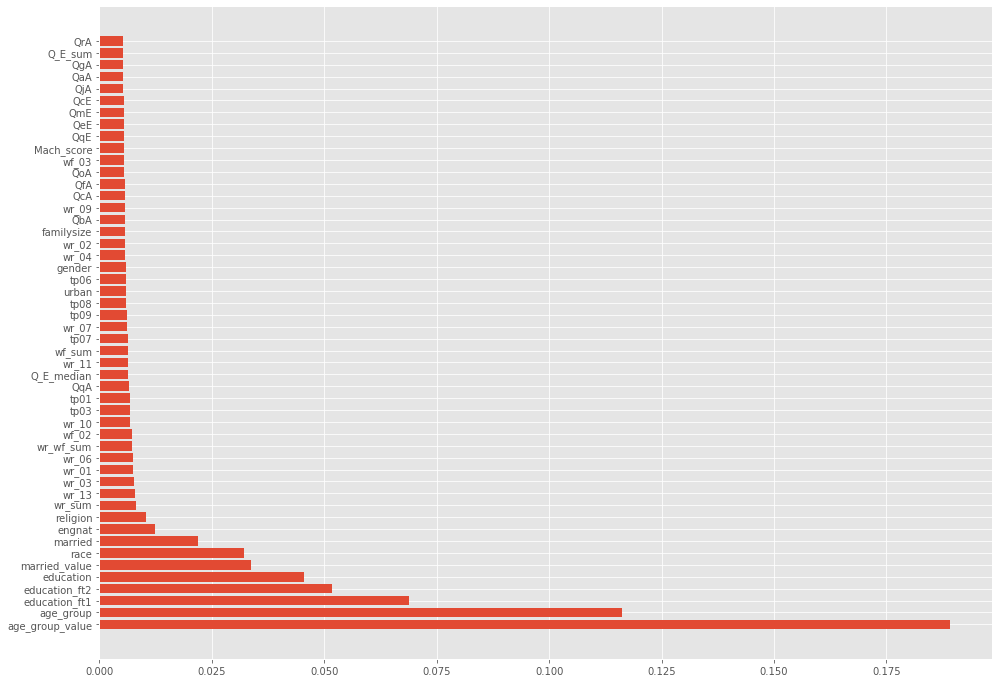

In [365]:
ft, test_preds, y_test = validation_model_xgb(tr,base_column)

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'Mach_score', 'wf_sum', 'Q_E_median']
제외변수 : []
[0]	validation_0-auc:0.76597	validation_1-auc:0.76585
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79418	validation_1-auc:0.77666
[200]	validation_0-auc:0.80490	validation_1-auc:0.77868
[300]	validation_0-auc:0.81569	validation_1-auc:0.77936
[400]	validation_0-auc:0.82627	validation_1-auc:0.77892
[500]	validation_0-auc:0.83629	validation_1-auc:0.77838
[600]	validation_0-auc:0.84532	validation_1-auc:0.77790
Stopping. Best iteration:
[324]	validation_0-auc:0.81824	validation_1-auc:0.77945

Fold  1 AUC : 0.779450
[0]	validation_0-auc:0.77237	validation_1-auc:0.74931
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn'

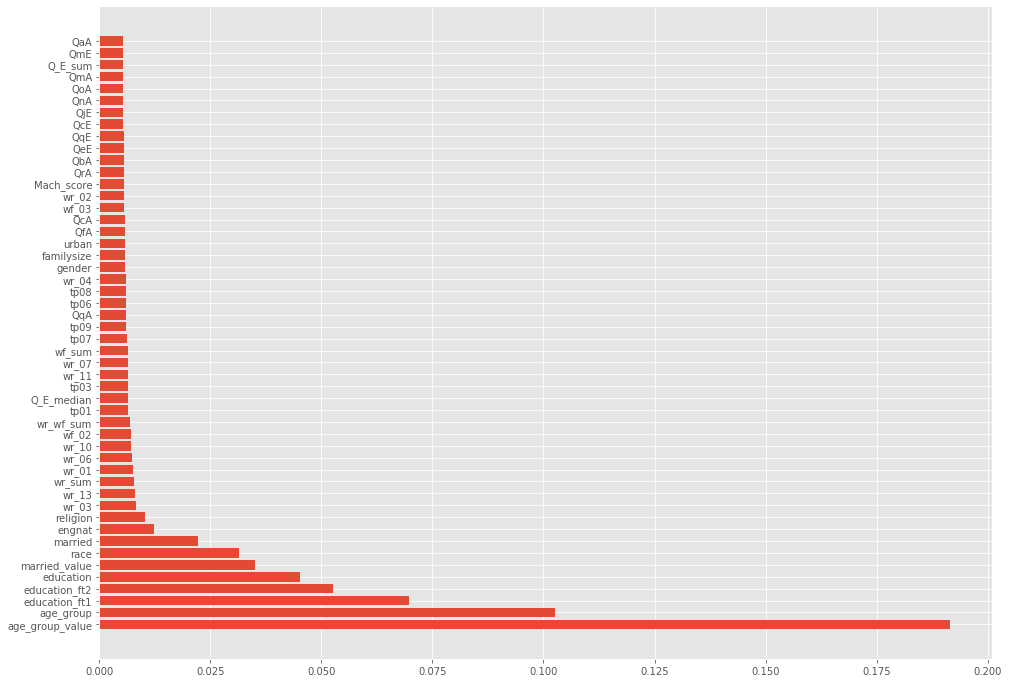

In [367]:
ft, test_preds, y_test = validation_model_xgb(tr,base_column)

추가변수 : ['education_ft2', 'age_group_value', 'wr_sum', 'married_value', 'wr_wf_sum', 'education_ft1', 'Q_E_sum', 'wf_sum', 'Q_E_median']
제외변수 : []
[0]	validation_0-auc:0.76818	validation_1-auc:0.75494
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79455	validation_1-auc:0.76798
[200]	validation_0-auc:0.80634	validation_1-auc:0.76961
[300]	validation_0-auc:0.81661	validation_1-auc:0.77022
[400]	validation_0-auc:0.82836	validation_1-auc:0.77060
[500]	validation_0-auc:0.83824	validation_1-auc:0.77007
[600]	validation_0-auc:0.84588	validation_1-auc:0.76957
Stopping. Best iteration:
[399]	validation_0-auc:0.82825	validation_1-auc:0.77063

Fold  1 AUC : 0.770628
[0]	validation_0-auc:0.77261	validation_1-auc:0.75232
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 

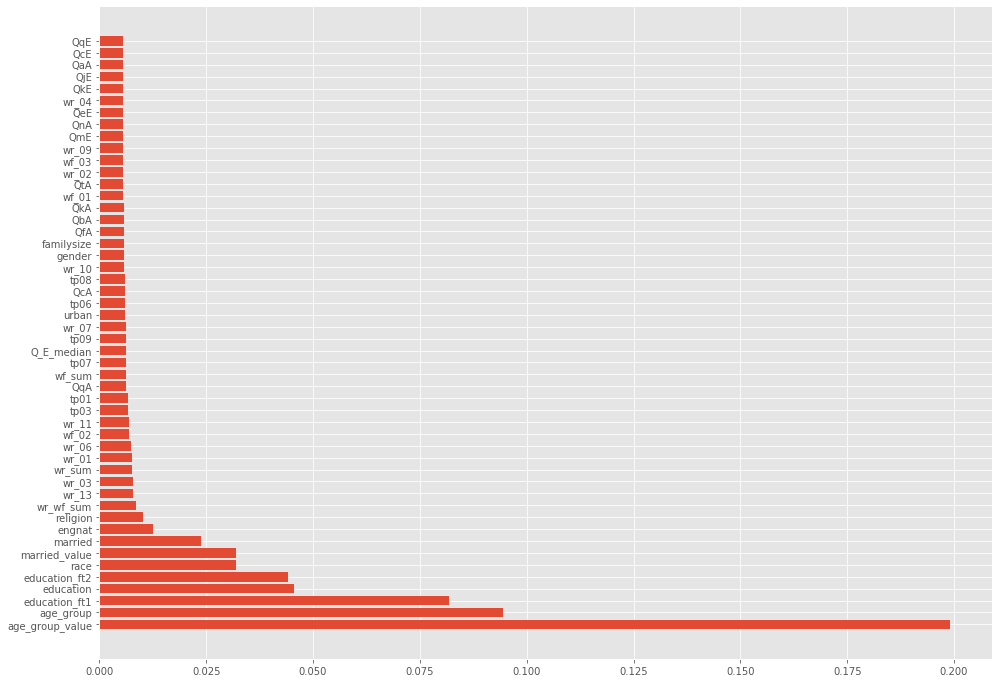

In [412]:
ft, test_preds, y_test = validation_model_xgb(tr,base_column)

추가변수 : ['QrE_log', 'QeE_log', 'QmE_log', 'QiE_log', 'QkE_log', 'education_ft1', 'Q_E_sum', 'QgE_log', 'QlE_log', 'QnE_log', 'QjE_log', 'education_ft2', 'wr_wf_mul', 'QdE_log', 'wr_wf_diff', 'wr_wf_sum', 'tp_mean', 'QhE_log', 'married_value', 'QsE_log', 'wf_wf_sum', 'Mach_score', 'QqE_log', 'Q_E_median', 'age_group_value', 'wr_wr_sum', 'wr_sum', 'QcE_log', 'QfE_log', 'QpE_log', 'QaE_log', 'QtE_log', 'tp_median', 'QoE_log', 'wf_sum', 'QbE_log']
제외변수 : ['QqE', 'QnE', 'QcE', 'QrE', 'QkE', 'QaE', 'QgE', 'QpE', 'QhE', 'QdE', 'QsE', 'QtE', 'QoE', 'QiE', 'QmE', 'QfE', 'QjE', 'QeE', 'QbE', 'QlE']
[0]	validation_0-auc:0.76836	validation_1-auc:0.75465
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79517	validation_1-auc:0.76600
[200]	validation_0-auc:0.80601	validation_1-auc:0.76831
[300]	validation_0-auc:0.81650	validation_1-auc:0.76967
[400]	validation_0-auc:0.

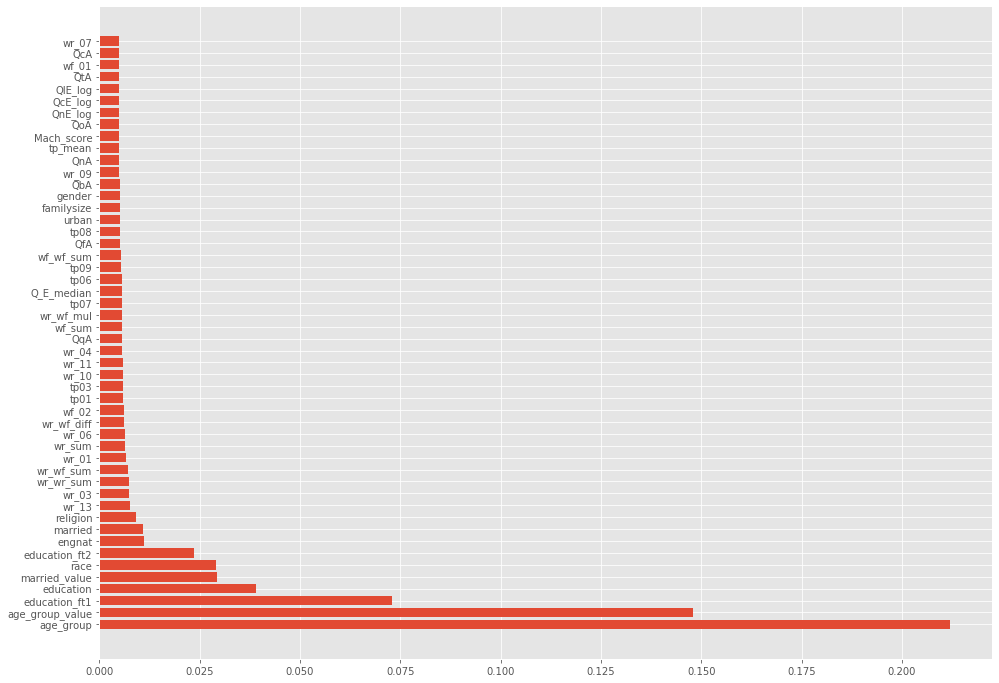

In [419]:
ft, test_preds, y_test = validation_model_xgb(tr,base_column)

### Catboost training

### Extra Tree training

### RF training

## Bayesian Optimization

In [619]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate

In [607]:
X = tr.drop(columns = 'voted')
y = tr['voted']

In [615]:
#목적함수 생성
def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):
    model = lgb.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = 1000,
                                #boosting = 'dart',
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                                feature_fraction = max(min(feature_fraction, 1), 0),
                                bagging_fraction = max(min(bagging_fraction, 1), 0),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0)
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, X, y, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score

In [616]:
pbounds = {'learning_rate' : (0.0001, 0.05),
           'num_leaves': (300, 600),
           'max_depth': (2, 25),
           'min_child_weight': (30, 100),
           'colsample_bytree': (0, 0.99),
           'feature_fraction': (0.0001, 0.99),
           'bagging_fraction': (0.0001, 0.99),
           'lambda_l1' : (0, 0.99),
           'lambda_l2' : (0, 0.99),
          }

In [617]:
lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 0 )


In [620]:
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7012   |  0.3797   |  0.7838   |  0.5237   |  0.5624   |  0.9163   |  0.003645 |  4.004    |  31.42    |  549.8    |
|  2        |  0.6954   |  0.7704   |  0.8613   |  0.9688   |  0.7912   |  0.4569   |  0.03905  |  4.72     |  74.79    |  343.0    |
|  3        |  0.6944   |  0.9352   |  0.5166   |  0.4106   |  0.2619   |  0.7665   |  0.02286  |  15.07    |  31.32    |  485.3    |
|  4        |  0.6906   |  0.606    |  0.6108   |  0.9343   |  0.675    |  0.3559   |  0.02191  |  18.05    |  34.22    |  500.0    |
|  5        |  0.696    |  0.664    |  0.2083   |  0.1277   |  0.3123   |  0.3601   |  0.02855  |  12.09    |  99.19    |  330.6    |
|  6        |  0.7026   |  0.2069   |  0.1597   |  0.6466   | 

In [621]:
lgbmBO.max

{'target': 0.7031378886953144,
 'params': {'bagging_fraction': 0.9669958011996147,
  'colsample_bytree': 0.5987970645475955,
  'feature_fraction': 0.7318970172463788,
  'lambda_l1': 0.03879591433177747,
  'lambda_l2': 0.2799788929506455,
  'learning_rate': 0.006097808404537128,
  'max_depth': 8.811224543009335,
  'min_child_weight': 38.31094032679708,
  'num_leaves': 395.3949538181928}}

# Testset inference

## inference code

In [625]:
def test_inference(tr, te, model_category):
    
    if model_category == 'lgb':
        X_train = tr.drop(columns = 'voted')
        y_train = tr['voted']

        folds = StratifiedKFold(n_splits=5, shuffle = True)
        test_preds = np.zeros(te.shape[0])
        feature_importance = pd.DataFrame()

        for n_folds, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

#             'bagging_fraction': 0.9669958011996147,
#   'colsample_bytree': 0.5987970645475955,
#   'feature_fraction': 0.7318970172463788,
#   'lambda_l1': 0.03879591433177747,
#   'lambda_l2': 0.2799788929506455,
#   'learning_rate': 0.006097808404537128,
#   'max_depth': 8.811224543009335,
#   'min_child_weight': 38.31094032679708,
#   'num_leaves': 395.3949538181928

#  bagging_fraction = 0.9515683153667026,
#                 colsample_bytree = 0.7860120233288207, # 0.78
#                 feature_fraction = 0.9362075859090412,
#                 lambda_l1 = 0.7111030183072032,
#                 lambda_l2 = 0.5642765168754059,
#                 learning_rate = 0.011407920284082697, # 0.011
#                 max_depth = 6,
#                 min_child_weight = 33,
#                 num_leaves = 380,
            clf = lgb.LGBMClassifier(
                n_estimators=1000,
                objective='binary',
                boosting_type='gbdt', # gbdt
               
                
                 bagging_fraction = 0.9669958011996147,
                colsample_bytree = 0.5987970645475955, # 0.78
                feature_fraction = 0.7318970172463788,
                lambda_l1 = 0.03879591433177747,
                lambda_l2 = 0.2799788929506455,
                learning_rate = 0.006097808404537128, # 0.011
                max_depth = 9,
                min_child_weight = 38,
                num_leaves = 395,
                random_state= 200,
            )

            clf.fit(
                train_x, train_y,
                eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric='auc', 
                verbose= 100, 
                early_stopping_rounds=300
            )

            test_preds += clf.predict_proba(te, num_iteration = clf.best_iteration_)[:,1] / folds.n_splits 

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_folds + 1
            feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

            #print('Fold %2d AUC : %.6f' % (n_folds + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        ft = feature_importance.groupby('feature')['importance'].mean().reset_index()
        ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

        feature_graph_df = feature_importance.sort_values('importance')
        plt.figure(figsize = (16,12))
        plt.barh(ft2['feature'],ft2['importance'])

        return ft2, test_preds
    
    elif model_category == 'xgb':
        X_train = tr.drop(columns = 'voted')
        y_train = tr['voted']

        folds = StratifiedKFold(n_splits=5, shuffle = True)
        test_preds = np.zeros(te.shape[0])
        feature_importance = pd.DataFrame()

        for n_folds, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            clf = xgb.XGBClassifier(
                n_estimators=1000,
                objective='binary:logistic',
                booster='gbtree', # gbtree
                colsample_bytree = 0.7860120233288207,
                learning_rate = 0.011407920284082697,#0.011->0.010
                max_depth = 7,
                min_child_weight = 33,
                random_state= 200,
            )
            
            clf.fit(
                train_x, 
                train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], 
                eval_metric='auc',
                verbose= 100, 
                early_stopping_rounds=300
            )
            
            test_preds += clf.predict_proba(te)[:,1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = X_train.columns
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_folds + 1
            feature_importance = pd.concat([feature_importance, fold_importance_df], axis=0)

            #print('Fold %2d AUC : %.6f' % (n_folds + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        ft = feature_importance.groupby('feature')['importance'].mean().reset_index()
        ft2 = ft.sort_values('importance',ascending = False).iloc[:50]

        feature_graph_df = feature_importance.sort_values('importance')
        plt.figure(figsize = (16,12))
        plt.barh(ft2['feature'],ft2['importance'])
        
        return ft2, test_preds

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.78081	training's binary_logloss: 0.573898	valid_1's auc: 0.760051	valid_1's binary_logloss: 0.584211
[200]	training's auc: 0.788855	training's binary_logloss: 0.548233	valid_1's auc: 0.762413	valid_1's binary_logloss: 0.566575
[300]	training's auc: 0.79599	training's binary_logloss: 0.537994	valid_1's auc: 0.763201	valid_1's binary_logloss: 0.563044
[400]	training's auc: 0.805902	training's binary_logloss: 0.529577	valid_1's auc: 0.763917	valid_1's binary_logloss: 0.562067
[500]	training's auc: 0.814356	training's binary_logloss: 0.522831	valid_1's auc: 0.764047	valid_1's binary_logloss: 0.561761
[600]	training's auc: 0.822084	training's binary_logloss: 0.516495	valid_1's auc: 0.763982	valid_1's binary_logloss: 0.561796
[700]	training's auc: 0.828723	training's binary_logloss: 0.510971	valid_1's auc: 0.764026	valid_1's binary_logloss: 0.561746
Early stopping, best iteration is:
[485]	training's auc: 0

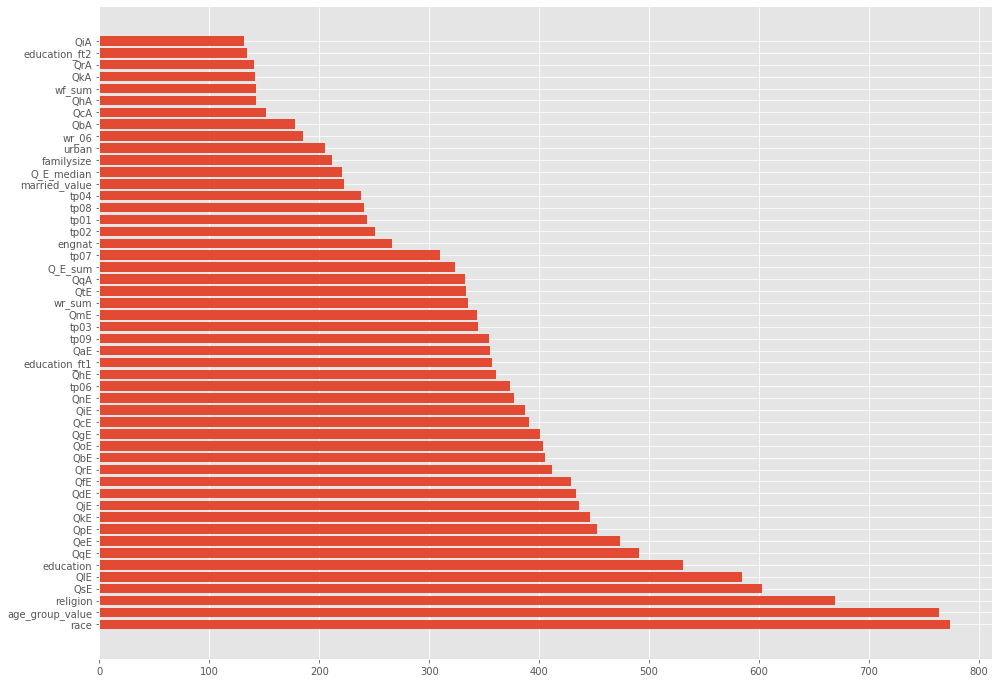

In [54]:
# random_state: 200 -> 0.7807
# ver1
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779859	training's binary_logloss: 0.575123	valid_1's auc: 0.764985	valid_1's binary_logloss: 0.581493
[200]	training's auc: 0.788338	training's binary_logloss: 0.549477	valid_1's auc: 0.766394	valid_1's binary_logloss: 0.562831
[300]	training's auc: 0.795928	training's binary_logloss: 0.538822	valid_1's auc: 0.7671	valid_1's binary_logloss: 0.558779
[400]	training's auc: 0.805715	training's binary_logloss: 0.530202	valid_1's auc: 0.767576	valid_1's binary_logloss: 0.557679
[500]	training's auc: 0.813402	training's binary_logloss: 0.523729	valid_1's auc: 0.767789	valid_1's binary_logloss: 0.557358
[600]	training's auc: 0.820439	training's binary_logloss: 0.517769	valid_1's auc: 0.767802	valid_1's binary_logloss: 0.5573
[700]	training's auc: 0.827511	training's binary_logloss: 0.511942	valid_1's auc: 0.767868	valid_1's binary_logloss: 0.557258
[800]	training's auc: 0.834231	training's binary_logloss: 0.

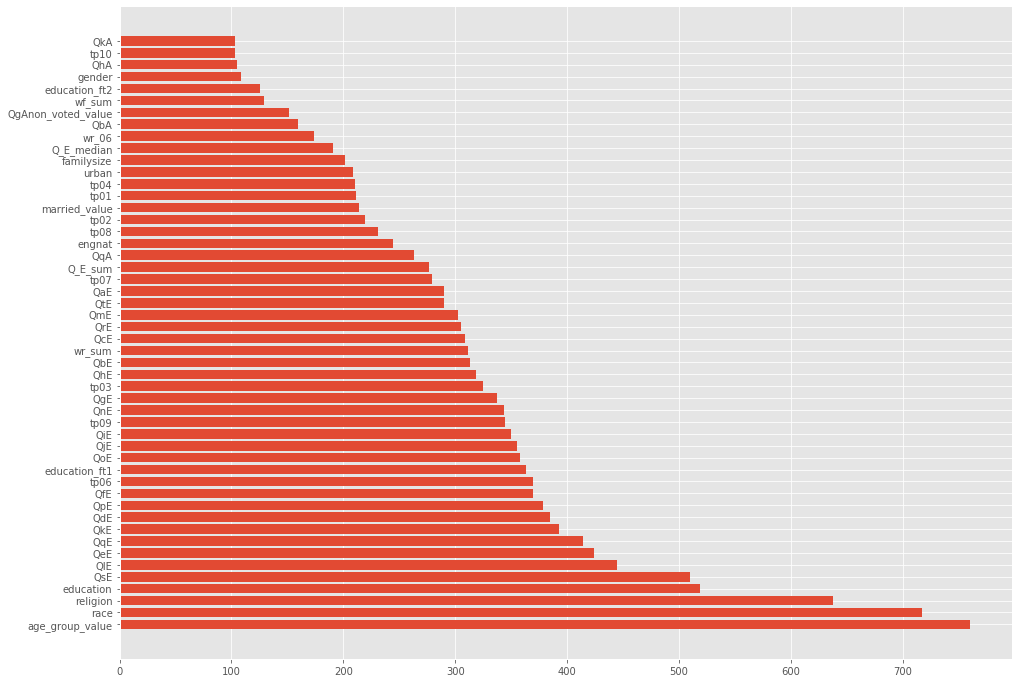

In [69]:
# ver2 -> 0.77898
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781876	training's binary_logloss: 0.573391	valid_1's auc: 0.751965	valid_1's binary_logloss: 0.588198
[200]	training's auc: 0.789496	training's binary_logloss: 0.547652	valid_1's auc: 0.754287	valid_1's binary_logloss: 0.57125
[300]	training's auc: 0.797197	training's binary_logloss: 0.537053	valid_1's auc: 0.755992	valid_1's binary_logloss: 0.567742
[400]	training's auc: 0.806738	training's binary_logloss: 0.52873	valid_1's auc: 0.756548	valid_1's binary_logloss: 0.567081
[500]	training's auc: 0.815575	training's binary_logloss: 0.521518	valid_1's auc: 0.756445	valid_1's binary_logloss: 0.567203
[600]	training's auc: 0.823024	training's binary_logloss: 0.51527	valid_1's auc: 0.756631	valid_1's binary_logloss: 0.567157
[700]	training's auc: 0.829893	training's binary_logloss: 0.509494	valid_1's auc: 0.756648	valid_1's binary_logloss: 0.567161
Early stopping, best iteration is:
[427]	training's auc: 0.

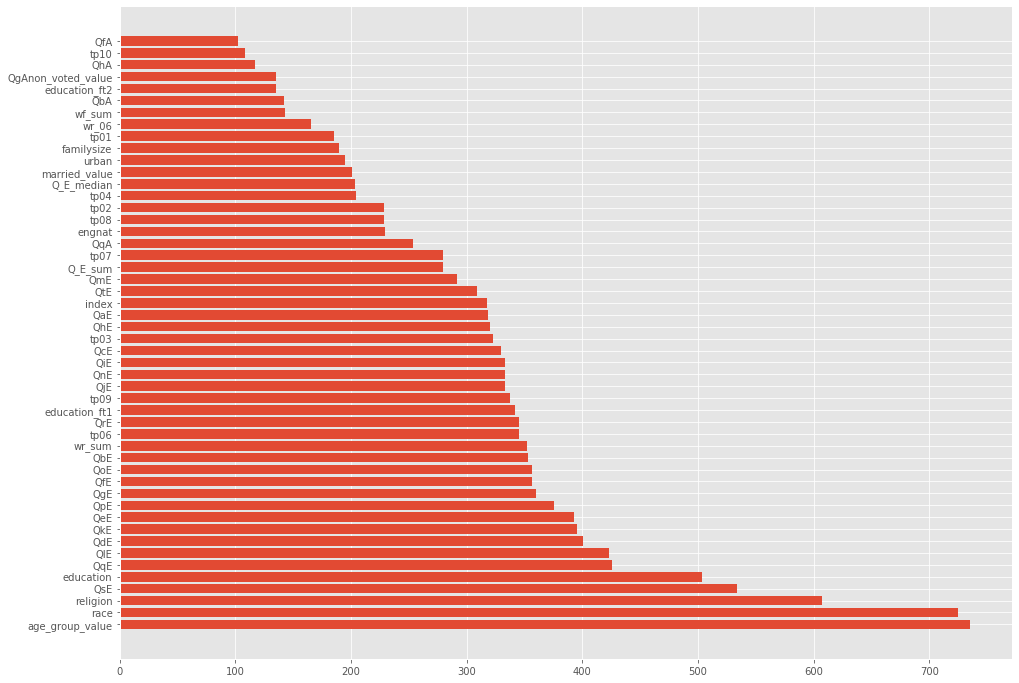

In [75]:
# ver3 -> 0.7788 쉣...
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779772	training's binary_logloss: 0.574742	valid_1's auc: 0.764181	valid_1's binary_logloss: 0.581407
[200]	training's auc: 0.787987	training's binary_logloss: 0.54931	valid_1's auc: 0.767268	valid_1's binary_logloss: 0.562575
[300]	training's auc: 0.795955	training's binary_logloss: 0.538577	valid_1's auc: 0.768767	valid_1's binary_logloss: 0.558073
[400]	training's auc: 0.806393	training's binary_logloss: 0.529752	valid_1's auc: 0.770155	valid_1's binary_logloss: 0.556606
[500]	training's auc: 0.8145	training's binary_logloss: 0.522971	valid_1's auc: 0.770127	valid_1's binary_logloss: 0.556285
[600]	training's auc: 0.821031	training's binary_logloss: 0.517364	valid_1's auc: 0.77015	valid_1's binary_logloss: 0.556156
[700]	training's auc: 0.828324	training's binary_logloss: 0.511231	valid_1's auc: 0.770287	valid_1's binary_logloss: 0.555931
[800]	training's auc: 0.836	training's binary_logloss: 0.504

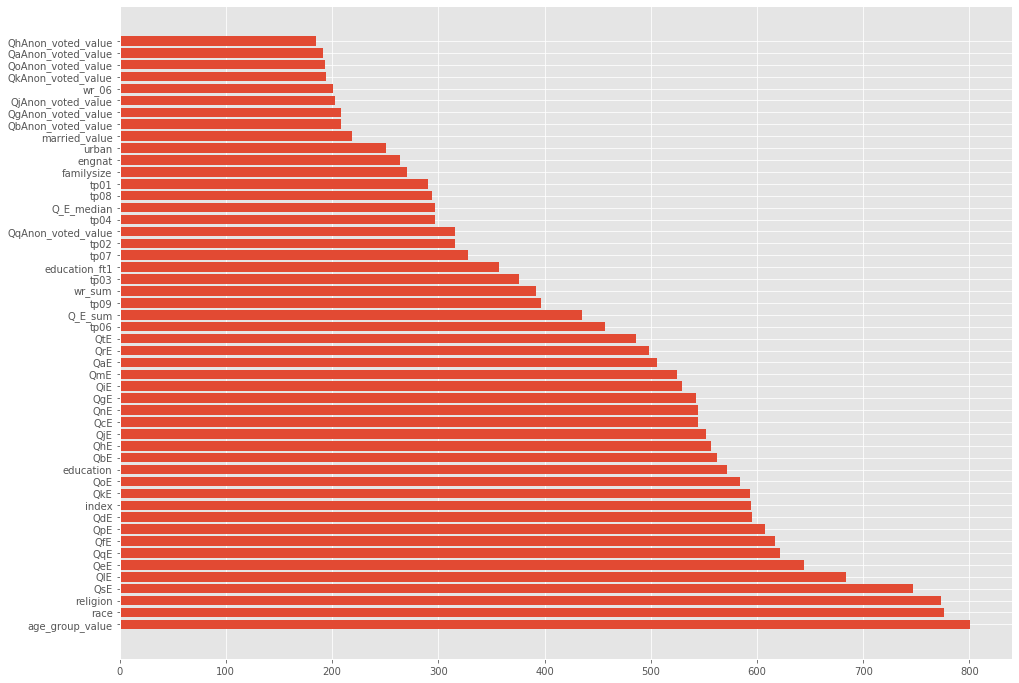

In [104]:
# ver4 > 0.77대
# mean encoding만 한 성능은 개선이 없엇음
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.778722	training's binary_logloss: 0.574865	valid_1's auc: 0.763967	valid_1's binary_logloss: 0.581229
[200]	training's auc: 0.787093	training's binary_logloss: 0.549799	valid_1's auc: 0.767016	valid_1's binary_logloss: 0.562556
[300]	training's auc: 0.794923	training's binary_logloss: 0.53933	valid_1's auc: 0.768042	valid_1's binary_logloss: 0.558412
[400]	training's auc: 0.805544	training's binary_logloss: 0.530431	valid_1's auc: 0.76941	valid_1's binary_logloss: 0.557016
[500]	training's auc: 0.814196	training's binary_logloss: 0.523375	valid_1's auc: 0.769528	valid_1's binary_logloss: 0.556741
[600]	training's auc: 0.82094	training's binary_logloss: 0.517782	valid_1's auc: 0.769555	valid_1's binary_logloss: 0.556782
[700]	training's auc: 0.827689	training's binary_logloss: 0.512132	valid_1's auc: 0.769744	valid_1's binary_logloss: 0.556686
[800]	training's auc: 0.834174	training's binary_logloss: 0

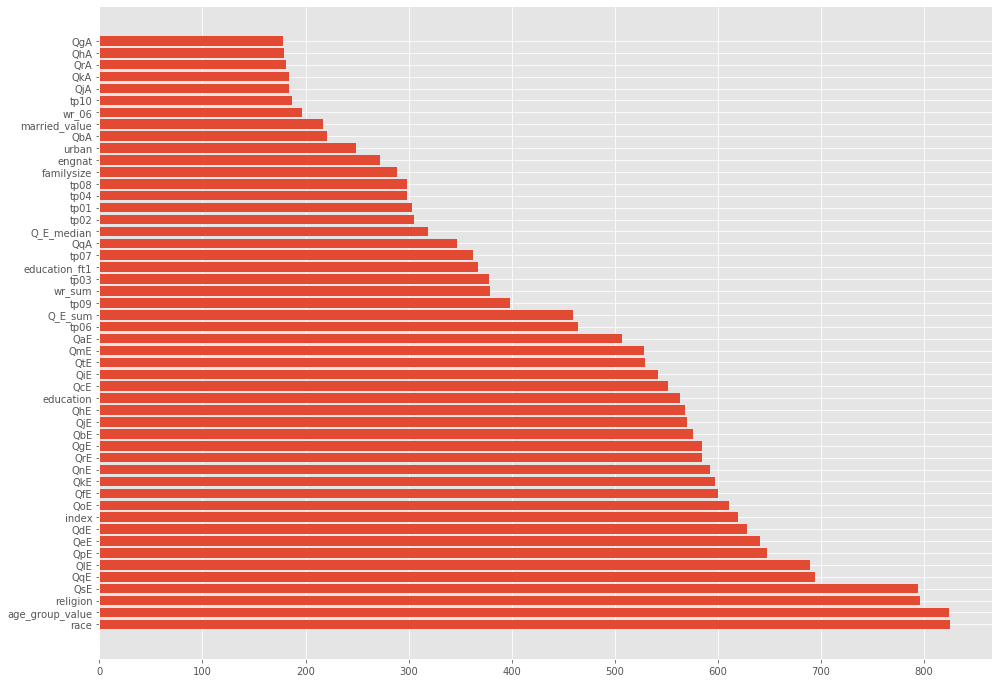

In [110]:
# 다시 ver1
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781576	training's binary_logloss: 0.573228	valid_1's auc: 0.750954	valid_1's binary_logloss: 0.587373
[200]	training's auc: 0.789468	training's binary_logloss: 0.547949	valid_1's auc: 0.753118	valid_1's binary_logloss: 0.57075
[300]	training's auc: 0.796376	training's binary_logloss: 0.537725	valid_1's auc: 0.754524	valid_1's binary_logloss: 0.567238
[400]	training's auc: 0.804914	training's binary_logloss: 0.530049	valid_1's auc: 0.754856	valid_1's binary_logloss: 0.566786
[500]	training's auc: 0.813461	training's binary_logloss: 0.522963	valid_1's auc: 0.755426	valid_1's binary_logloss: 0.566391
[600]	training's auc: 0.820415	training's binary_logloss: 0.517125	valid_1's auc: 0.755603	valid_1's binary_logloss: 0.566342
[700]	training's auc: 0.826816	training's binary_logloss: 0.511712	valid_1's auc: 0.75558	valid_1's binary_logloss: 0.56643
[800]	training's auc: 0.833357	training's binary_logloss: 0

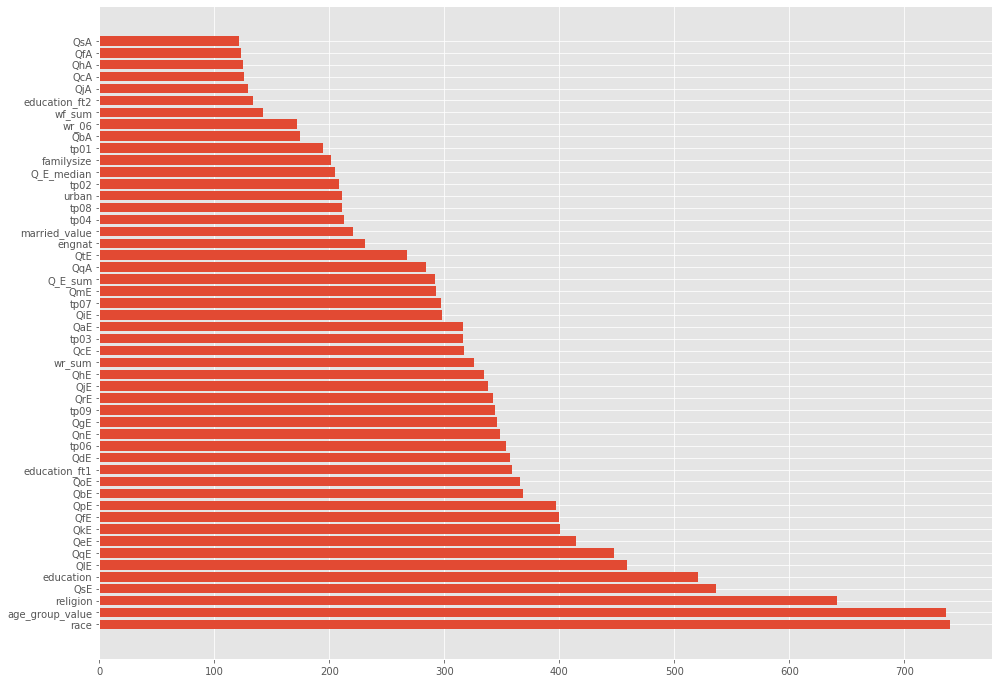

In [263]:
# 다시 ver1 -> 0.7802
# 성능이 말도 안되게 떨어졌는데;;341 슈바 0.78075;; 찍어야되는디
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781751	training's binary_logloss: 0.572817	valid_1's auc: 0.75343	valid_1's binary_logloss: 0.586669
[200]	training's auc: 0.790048	training's binary_logloss: 0.547377	valid_1's auc: 0.755337	valid_1's binary_logloss: 0.570031
[300]	training's auc: 0.796788	training's binary_logloss: 0.537178	valid_1's auc: 0.756492	valid_1's binary_logloss: 0.566276
[400]	training's auc: 0.805342	training's binary_logloss: 0.529592	valid_1's auc: 0.756857	valid_1's binary_logloss: 0.565737
[500]	training's auc: 0.813705	training's binary_logloss: 0.522554	valid_1's auc: 0.757216	valid_1's binary_logloss: 0.56544
[600]	training's auc: 0.821514	training's binary_logloss: 0.516053	valid_1's auc: 0.757387	valid_1's binary_logloss: 0.565391
[700]	training's auc: 0.828376	training's binary_logloss: 0.510257	valid_1's auc: 0.757155	valid_1's binary_logloss: 0.56559
[800]	training's auc: 0.83484	training's binary_logloss: 0.

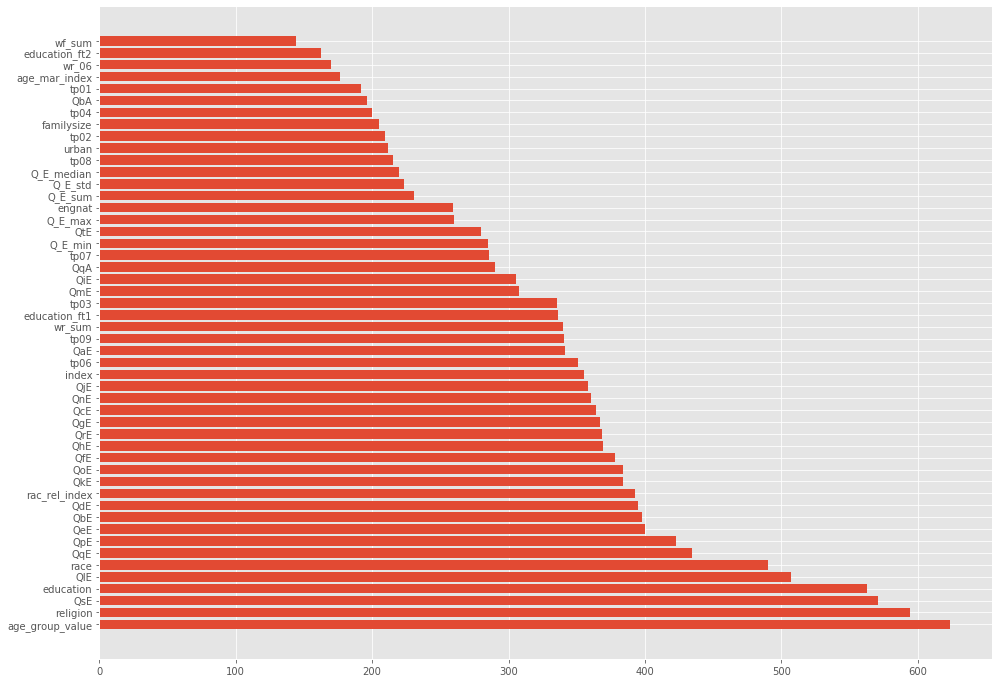

In [223]:
# ver5 -> 0.7788
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781944	training's binary_logloss: 0.573172	valid_1's auc: 0.750935	valid_1's binary_logloss: 0.587417
[200]	training's auc: 0.789803	training's binary_logloss: 0.547827	valid_1's auc: 0.753109	valid_1's binary_logloss: 0.570839
[300]	training's auc: 0.796266	training's binary_logloss: 0.537745	valid_1's auc: 0.754737	valid_1's binary_logloss: 0.567128
[400]	training's auc: 0.805035	training's binary_logloss: 0.529964	valid_1's auc: 0.755011	valid_1's binary_logloss: 0.566677
[500]	training's auc: 0.813621	training's binary_logloss: 0.522924	valid_1's auc: 0.755204	valid_1's binary_logloss: 0.566563
[600]	training's auc: 0.82126	training's binary_logloss: 0.516573	valid_1's auc: 0.755559	valid_1's binary_logloss: 0.566364
[700]	training's auc: 0.828422	training's binary_logloss: 0.510556	valid_1's auc: 0.755697	valid_1's binary_logloss: 0.566374
[800]	training's auc: 0.834747	training's binary_logloss:

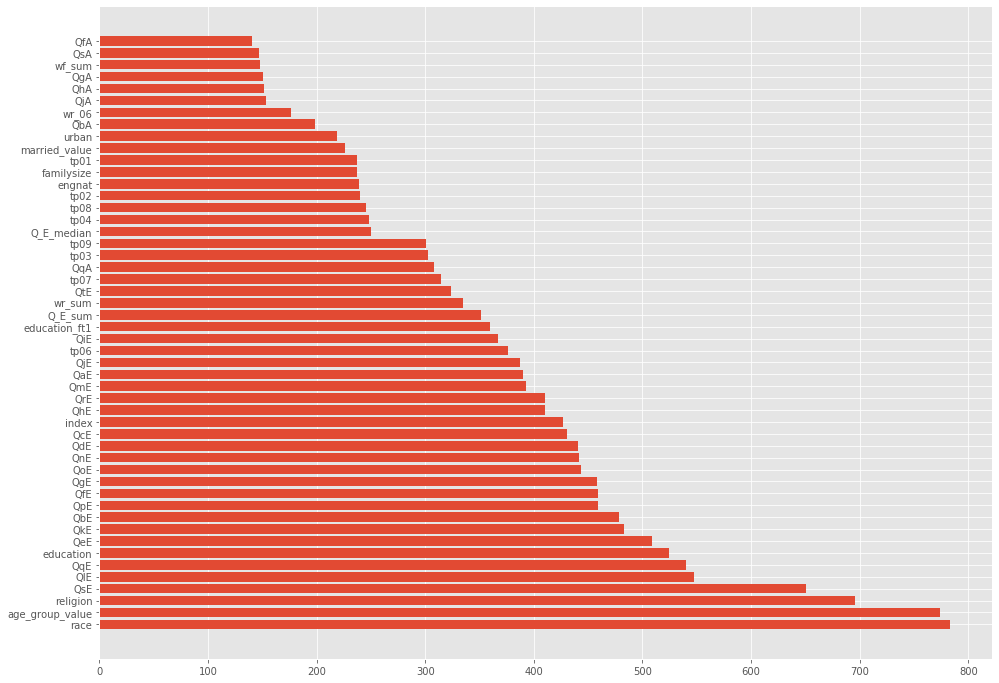

In [236]:
# ver6 -> 성능 확인해야 함 -> 0.78023
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.782438	training's binary_logloss: 0.573216	valid_1's auc: 0.75154	valid_1's binary_logloss: 0.587357
[200]	training's auc: 0.789843	training's binary_logloss: 0.547809	valid_1's auc: 0.753343	valid_1's binary_logloss: 0.570649
[300]	training's auc: 0.796507	training's binary_logloss: 0.537676	valid_1's auc: 0.754689	valid_1's binary_logloss: 0.567086
[400]	training's auc: 0.804845	training's binary_logloss: 0.530155	valid_1's auc: 0.75504	valid_1's binary_logloss: 0.566587
[500]	training's auc: 0.81387	training's binary_logloss: 0.522734	valid_1's auc: 0.755448	valid_1's binary_logloss: 0.566294
[600]	training's auc: 0.821098	training's binary_logloss: 0.516717	valid_1's auc: 0.755861	valid_1's binary_logloss: 0.566093
[700]	training's auc: 0.828143	training's binary_logloss: 0.510804	valid_1's auc: 0.756014	valid_1's binary_logloss: 0.566117
[800]	training's auc: 0.834415	training's binary_logloss: 0

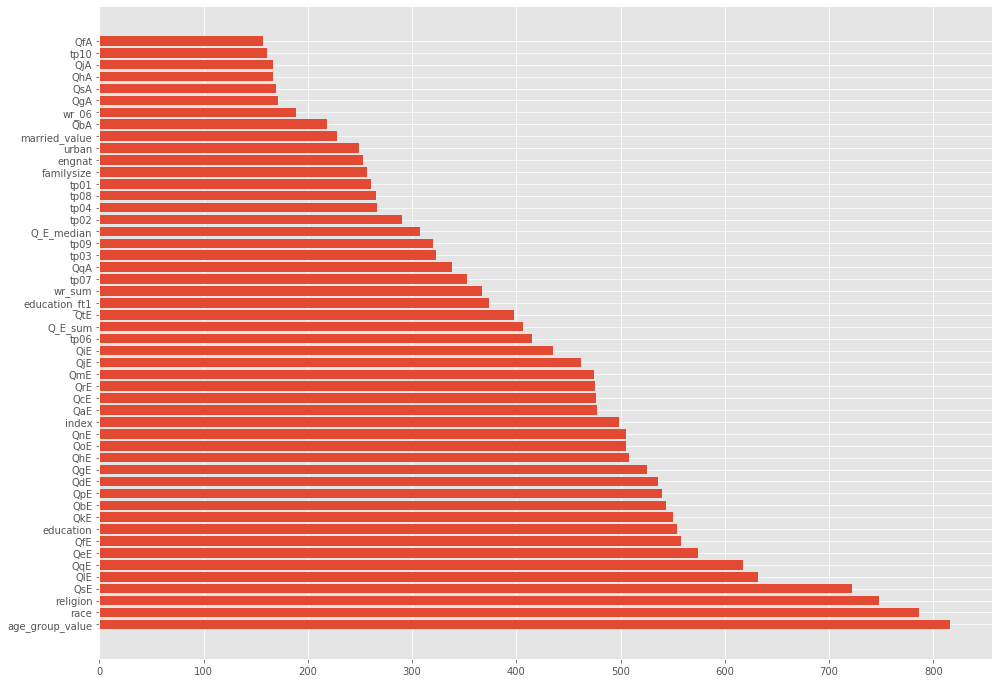

In [250]:
# ver6 -> tp 일부만 떼서 확인
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781647	training's binary_logloss: 0.573832	valid_1's auc: 0.755203	valid_1's binary_logloss: 0.585075
[200]	training's auc: 0.789324	training's binary_logloss: 0.548507	valid_1's auc: 0.756699	valid_1's binary_logloss: 0.567781
[300]	training's auc: 0.79679	training's binary_logloss: 0.538151	valid_1's auc: 0.757297	valid_1's binary_logloss: 0.564575
[400]	training's auc: 0.805632	training's binary_logloss: 0.530178	valid_1's auc: 0.757377	valid_1's binary_logloss: 0.56415
[500]	training's auc: 0.813717	training's binary_logloss: 0.523247	valid_1's auc: 0.757806	valid_1's binary_logloss: 0.563862
[600]	training's auc: 0.821176	training's binary_logloss: 0.516883	valid_1's auc: 0.758287	valid_1's binary_logloss: 0.563533
[700]	training's auc: 0.828182	training's binary_logloss: 0.510906	valid_1's auc: 0.758333	valid_1's binary_logloss: 0.563456
[800]	training's auc: 0.834409	training's binary_logloss: 

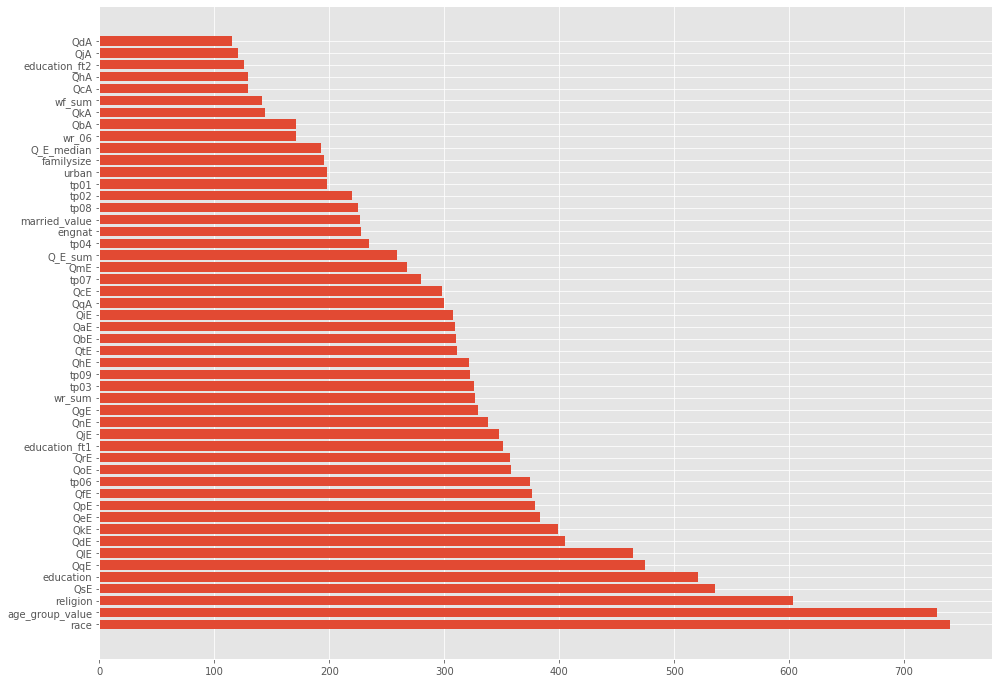

In [276]:
# random_state = 111로 제출해보자

ft_df, test_preds = test_inference(tr,te,111)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781413	training's binary_logloss: 0.573863	valid_1's auc: 0.75519	valid_1's binary_logloss: 0.585119
[200]	training's auc: 0.789418	training's binary_logloss: 0.548407	valid_1's auc: 0.756551	valid_1's binary_logloss: 0.567862
[300]	training's auc: 0.796845	training's binary_logloss: 0.538052	valid_1's auc: 0.757334	valid_1's binary_logloss: 0.564509
[400]	training's auc: 0.80527	training's binary_logloss: 0.530286	valid_1's auc: 0.757318	valid_1's binary_logloss: 0.564058
[500]	training's auc: 0.813222	training's binary_logloss: 0.523571	valid_1's auc: 0.757603	valid_1's binary_logloss: 0.563893
[600]	training's auc: 0.820563	training's binary_logloss: 0.517224	valid_1's auc: 0.757886	valid_1's binary_logloss: 0.563726
[700]	training's auc: 0.827103	training's binary_logloss: 0.51164	valid_1's auc: 0.757601	valid_1's binary_logloss: 0.563898
[800]	training's auc: 0.833126	training's binary_logloss: 0

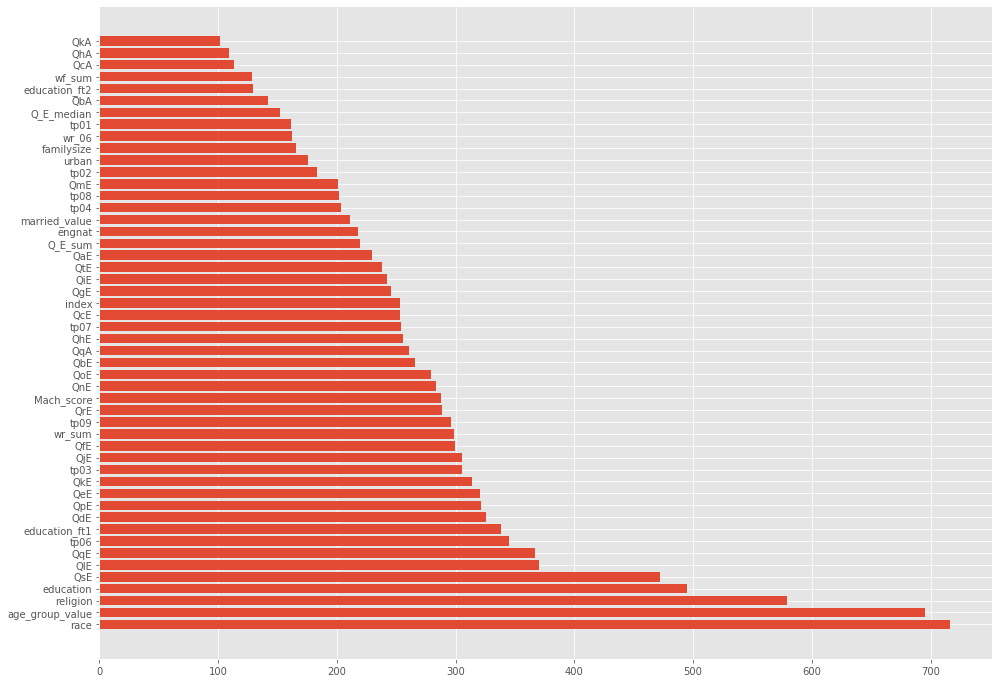

In [295]:
# 마키밸리아 변수 추가한 뒤 rs = 111
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779246	training's binary_logloss: 0.574765	valid_1's auc: 0.761126	valid_1's binary_logloss: 0.582049
[200]	training's auc: 0.787559	training's binary_logloss: 0.549483	valid_1's auc: 0.76357	valid_1's binary_logloss: 0.563764
[300]	training's auc: 0.795749	training's binary_logloss: 0.539	valid_1's auc: 0.76522	valid_1's binary_logloss: 0.559297
[400]	training's auc: 0.805636	training's binary_logloss: 0.530377	valid_1's auc: 0.766059	valid_1's binary_logloss: 0.557873
[500]	training's auc: 0.813652	training's binary_logloss: 0.523601	valid_1's auc: 0.766255	valid_1's binary_logloss: 0.557694
[600]	training's auc: 0.821431	training's binary_logloss: 0.517203	valid_1's auc: 0.766434	valid_1's binary_logloss: 0.557639
[700]	training's auc: 0.828569	training's binary_logloss: 0.511352	valid_1's auc: 0.766687	valid_1's binary_logloss: 0.557635
[800]	training's auc: 0.835584	training's binary_logloss: 0.5

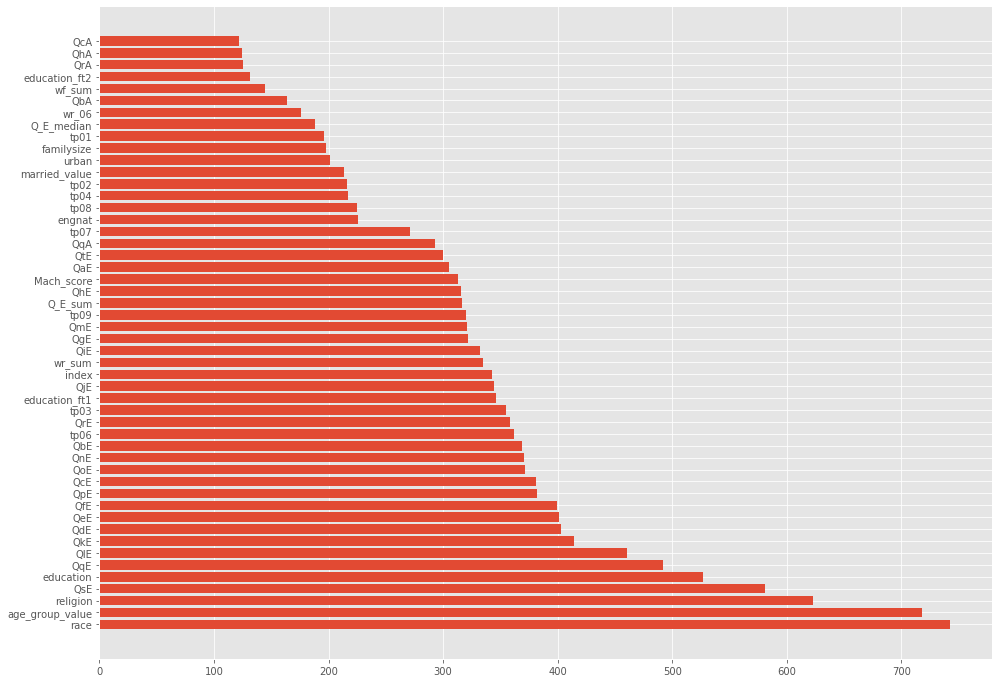

In [300]:
# 마키밸리아 변수 추가한 뒤 rs = None
ft_df, test_preds = test_inference(tr,te)

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781506	training's binary_logloss: 0.574122	valid_1's auc: 0.755131	valid_1's binary_logloss: 0.585805
[200]	training's auc: 0.789464	training's binary_logloss: 0.548684	valid_1's auc: 0.758077	valid_1's binary_logloss: 0.56818
[300]	training's auc: 0.796374	training's binary_logloss: 0.538481	valid_1's auc: 0.760242	valid_1's binary_logloss: 0.563716
[400]	training's auc: 0.804876	training's binary_logloss: 0.530803	valid_1's auc: 0.761229	valid_1's binary_logloss: 0.562363
[500]	training's auc: 0.812062	training's binary_logloss: 0.524839	valid_1's auc: 0.761492	valid_1's binary_logloss: 0.561925
[600]	training's auc: 0.819281	training's binary_logloss: 0.519007	valid_1's auc: 0.76181	valid_1's binary_logloss: 0.561682
[700]	training's auc: 0.826412	training's binary_logloss: 0.513203	valid_1's auc: 0.761861	valid_1's binary_logloss: 0.561689
[800]	training's auc: 0.833306	training's binary_logloss: 

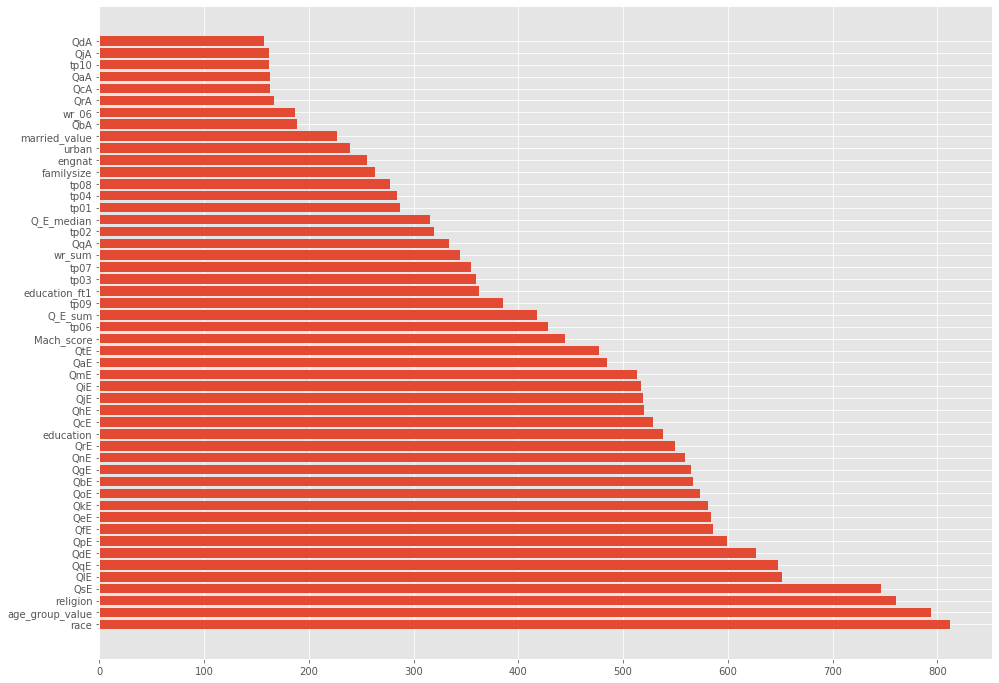

In [370]:
# 제출 31
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

[0]	validation_0-auc:0.76168	validation_1-auc:0.76331
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.78022	validation_1-auc:0.77464
[200]	validation_0-auc:0.78772	validation_1-auc:0.77601
[300]	validation_0-auc:0.79555	validation_1-auc:0.77735
[400]	validation_0-auc:0.80361	validation_1-auc:0.77774
[500]	validation_0-auc:0.81071	validation_1-auc:0.77753
[600]	validation_0-auc:0.81729	validation_1-auc:0.77746
Stopping. Best iteration:
[386]	validation_0-auc:0.80239	validation_1-auc:0.77790

[0]	validation_0-auc:0.76432	validation_1-auc:0.75417
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.78274	validation_1-auc:0.76181
[200]	validation_0-auc:0.78974	validation_1-auc:0.76320
[300]	validation_0-auc:0.79643	validation_1-a

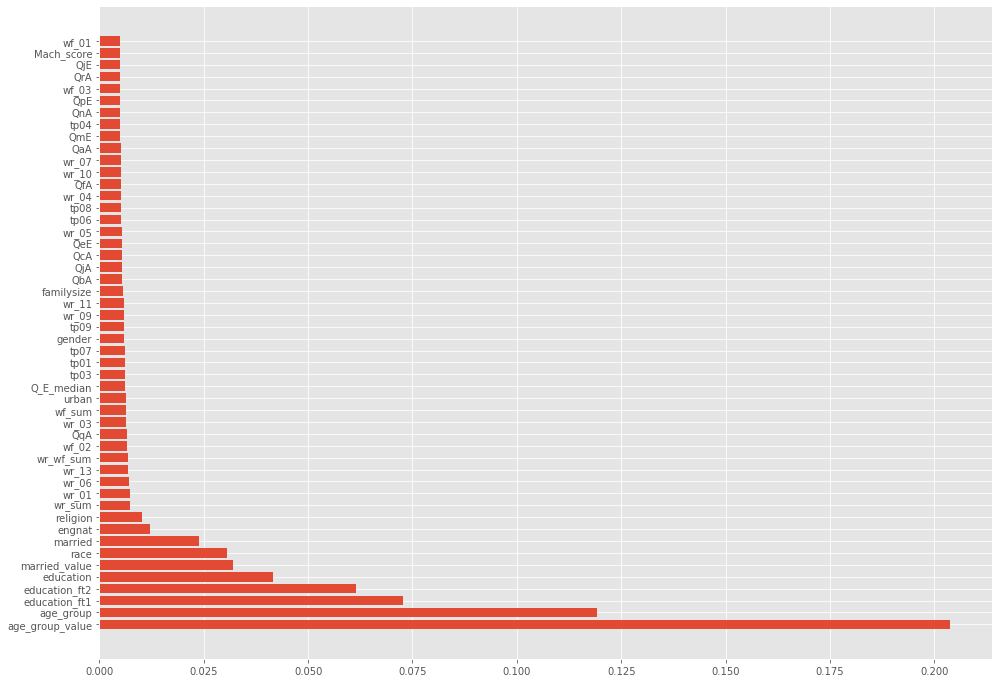

In [347]:
# 제출 31
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'xgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779713	training's binary_logloss: 0.574861	valid_1's auc: 0.764789	valid_1's binary_logloss: 0.581216
[200]	training's auc: 0.787899	training's binary_logloss: 0.549562	valid_1's auc: 0.767411	valid_1's binary_logloss: 0.561928
[300]	training's auc: 0.794786	training's binary_logloss: 0.539568	valid_1's auc: 0.768689	valid_1's binary_logloss: 0.557378
[400]	training's auc: 0.804621	training's binary_logloss: 0.531296	valid_1's auc: 0.769727	valid_1's binary_logloss: 0.555804
[500]	training's auc: 0.811831	training's binary_logloss: 0.525396	valid_1's auc: 0.769857	valid_1's binary_logloss: 0.555395
[600]	training's auc: 0.818769	training's binary_logloss: 0.519892	valid_1's auc: 0.769846	valid_1's binary_logloss: 0.55525
[700]	training's auc: 0.825783	training's binary_logloss: 0.51419	valid_1's auc: 0.769808	valid_1's binary_logloss: 0.55523
[800]	training's auc: 0.832518	training's binary_logloss: 0

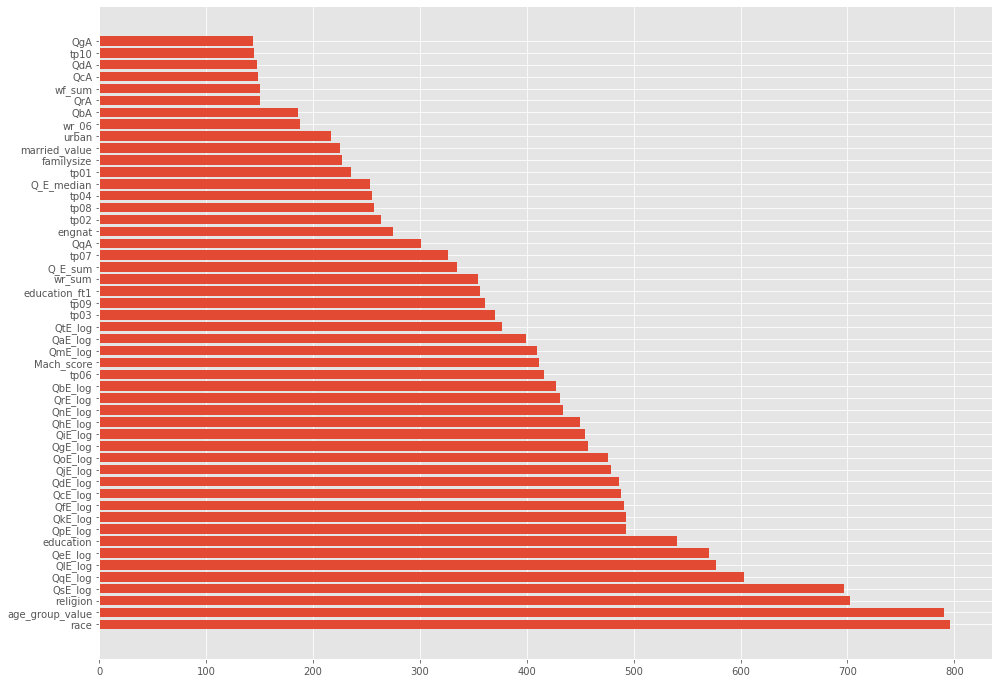

In [379]:
# 제출 32
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

[0]	validation_0-auc:0.76682	validation_1-auc:0.74769
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79300	validation_1-auc:0.76273
[200]	validation_0-auc:0.80373	validation_1-auc:0.76536
[300]	validation_0-auc:0.81297	validation_1-auc:0.76636
[400]	validation_0-auc:0.82312	validation_1-auc:0.76700
[500]	validation_0-auc:0.83233	validation_1-auc:0.76679
[600]	validation_0-auc:0.83989	validation_1-auc:0.76638
[700]	validation_0-auc:0.84710	validation_1-auc:0.76619
Stopping. Best iteration:
[403]	validation_0-auc:0.82338	validation_1-auc:0.76704

[0]	validation_0-auc:0.76598	validation_1-auc:0.75809
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79337	validation_1-auc:0.76879
[200]	validation_0-auc:0.80340	validation_1-a

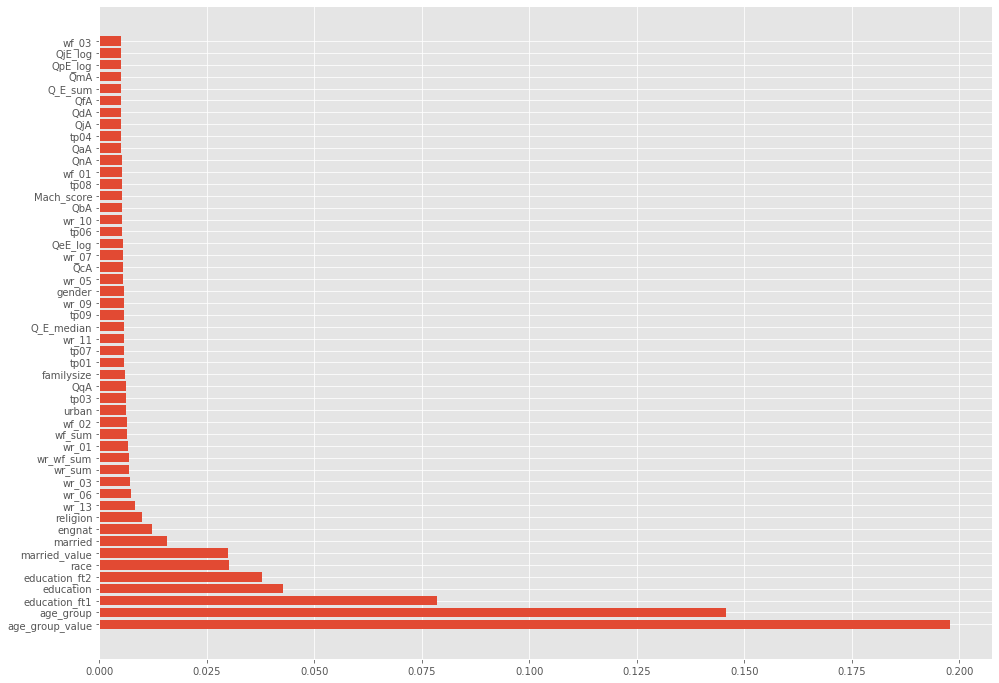

In [380]:
# 제출 32
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'xgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.778464	training's binary_logloss: 0.575365	valid_1's auc: 0.764249	valid_1's binary_logloss: 0.582189
[200]	training's auc: 0.786993	training's binary_logloss: 0.549879	valid_1's auc: 0.765749	valid_1's binary_logloss: 0.563723
[300]	training's auc: 0.793947	training's binary_logloss: 0.539919	valid_1's auc: 0.767265	valid_1's binary_logloss: 0.559483
[400]	training's auc: 0.803589	training's binary_logloss: 0.531757	valid_1's auc: 0.767883	valid_1's binary_logloss: 0.558336
[500]	training's auc: 0.812241	training's binary_logloss: 0.524743	valid_1's auc: 0.768452	valid_1's binary_logloss: 0.557813
[600]	training's auc: 0.818549	training's binary_logloss: 0.519502	valid_1's auc: 0.768431	valid_1's binary_logloss: 0.557823
[700]	training's auc: 0.824955	training's binary_logloss: 0.514166	valid_1's auc: 0.768196	valid_1's binary_logloss: 0.558019
[800]	training's auc: 0.831225	training's binary_logloss

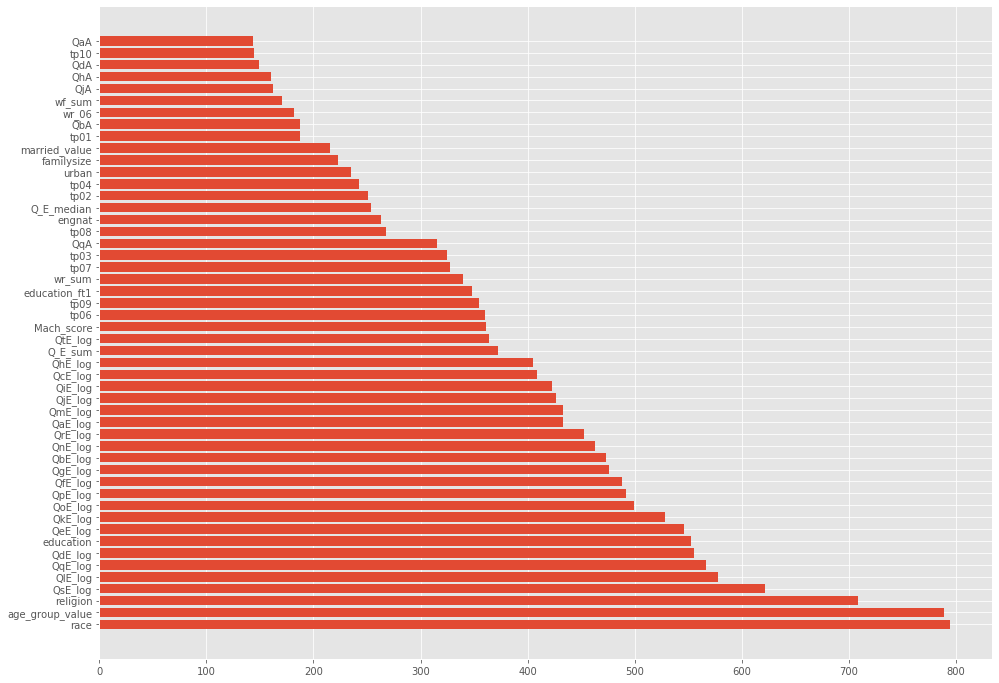

In [390]:
# 제출 33
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

[0]	validation_0-auc:0.76739	validation_1-auc:0.75799
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79345	validation_1-auc:0.76968
[200]	validation_0-auc:0.80400	validation_1-auc:0.77159
[300]	validation_0-auc:0.81294	validation_1-auc:0.77257
[400]	validation_0-auc:0.82082	validation_1-auc:0.77288
[500]	validation_0-auc:0.82925	validation_1-auc:0.77266
[600]	validation_0-auc:0.83637	validation_1-auc:0.77261
Stopping. Best iteration:
[394]	validation_0-auc:0.82047	validation_1-auc:0.77293

[0]	validation_0-auc:0.77178	validation_1-auc:0.74440
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79587	validation_1-auc:0.75317
[200]	validation_0-auc:0.80637	validation_1-auc:0.75504
[300]	validation_0-auc:0.81588	validation_1-a

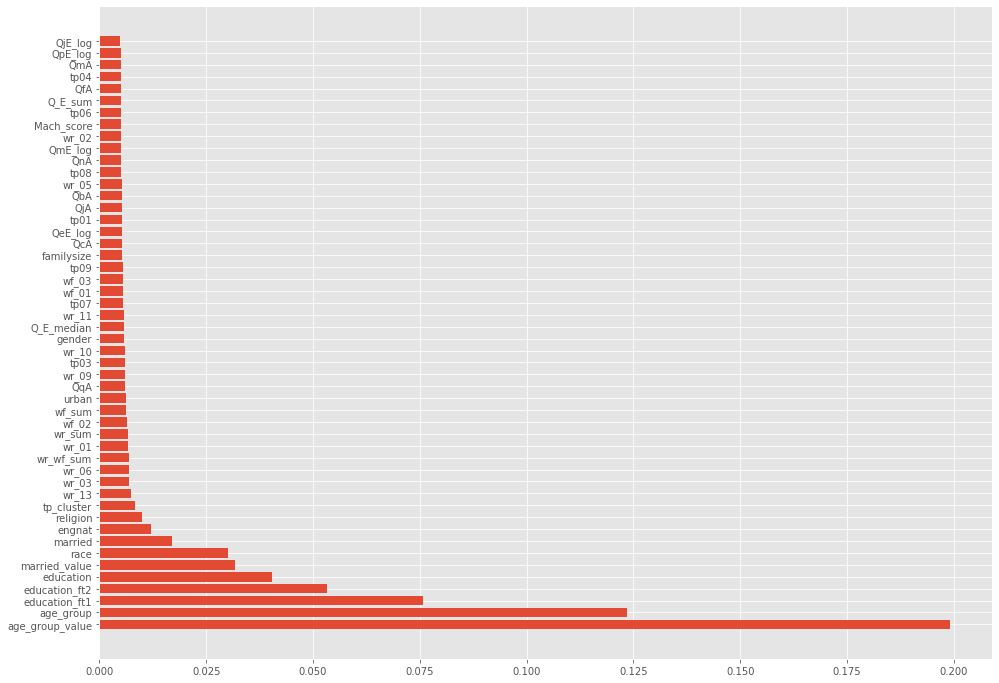

In [391]:
# 제출 33
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'xgb')

[100]	training's auc: 0.77496	training's binary_logloss: 0.614453	valid_1's auc: 0.766601	valid_1's binary_logloss: 0.615225
[200]	training's auc: 0.777797	training's binary_logloss: 0.593913	valid_1's auc: 0.767028	valid_1's binary_logloss: 0.595738
[300]	training's auc: 0.778975	training's binary_logloss: 0.588998	valid_1's auc: 0.767521	valid_1's binary_logloss: 0.591266
[400]	training's auc: 0.780706	training's binary_logloss: 0.577311	valid_1's auc: 0.767908	valid_1's binary_logloss: 0.580584
[500]	training's auc: 0.781948	training's binary_logloss: 0.573701	valid_1's auc: 0.768065	valid_1's binary_logloss: 0.577584
[600]	training's auc: 0.78573	training's binary_logloss: 0.562333	valid_1's auc: 0.768711	valid_1's binary_logloss: 0.568184
[700]	training's auc: 0.787923	training's binary_logloss: 0.558433	valid_1's auc: 0.769428	valid_1's binary_logloss: 0.56523
[800]	training's auc: 0.790697	training's binary_logloss: 0.553219	valid_1's auc: 0.77036	valid_1's binary_logloss: 0.561

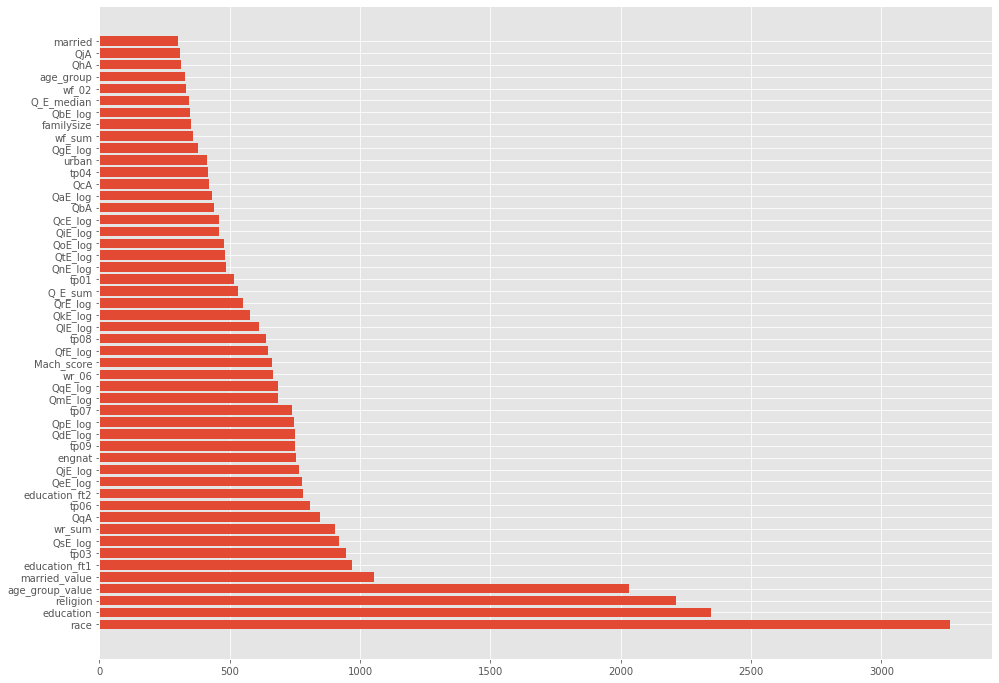

In [401]:
# 제출 34
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

[0]	validation_0-auc:0.76670	validation_1-auc:0.75219
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79322	validation_1-auc:0.76067
[200]	validation_0-auc:0.80373	validation_1-auc:0.76291
[300]	validation_0-auc:0.81439	validation_1-auc:0.76379
[400]	validation_0-auc:0.82394	validation_1-auc:0.76413
[500]	validation_0-auc:0.83109	validation_1-auc:0.76412
[600]	validation_0-auc:0.83780	validation_1-auc:0.76408
[700]	validation_0-auc:0.84430	validation_1-auc:0.76377
Stopping. Best iteration:
[429]	validation_0-auc:0.82610	validation_1-auc:0.76422

[0]	validation_0-auc:0.76492	validation_1-auc:0.75614
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79136	validation_1-auc:0.77023
[200]	validation_0-auc:0.80152	validation_1-a

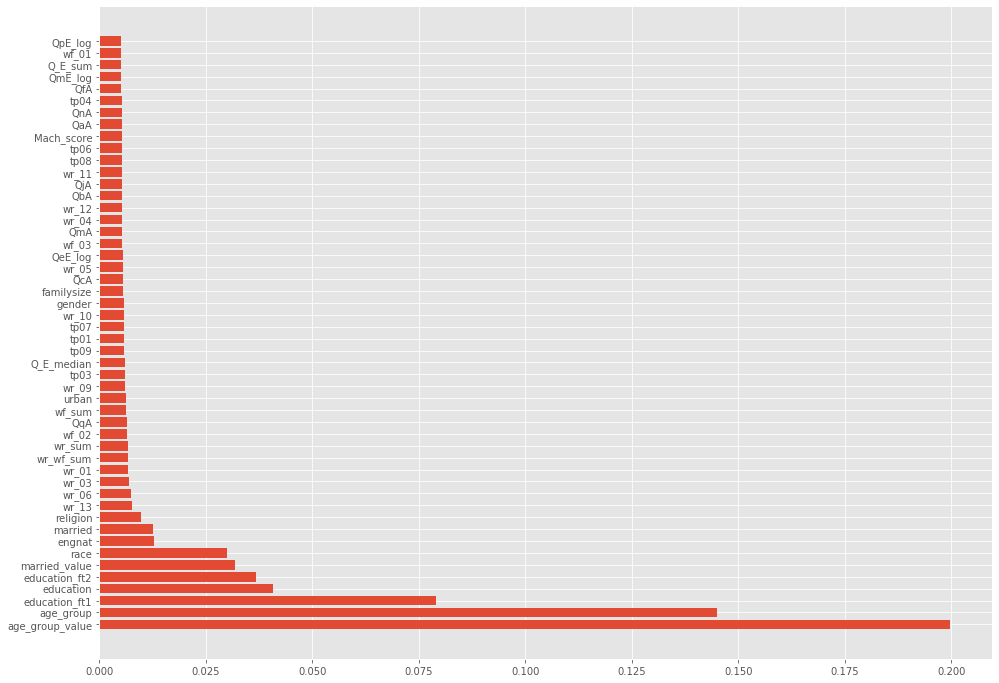

In [402]:
# 제출 34
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'xgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779284	training's binary_logloss: 0.575428	valid_1's auc: 0.76737	valid_1's binary_logloss: 0.58015
[200]	training's auc: 0.786456	training's binary_logloss: 0.55051	valid_1's auc: 0.770157	valid_1's binary_logloss: 0.560113
[300]	training's auc: 0.793853	training's binary_logloss: 0.540195	valid_1's auc: 0.771222	valid_1's binary_logloss: 0.555371
[400]	training's auc: 0.804106	training's binary_logloss: 0.53164	valid_1's auc: 0.771554	valid_1's binary_logloss: 0.55426
[500]	training's auc: 0.812341	training's binary_logloss: 0.524992	valid_1's auc: 0.771314	valid_1's binary_logloss: 0.554057
[600]	training's auc: 0.819542	training's binary_logloss: 0.51919	valid_1's auc: 0.770696	valid_1's binary_logloss: 0.5542
Early stopping, best iteration is:
[341]	training's auc: 0.797427	training's binary_logloss: 0.536861	valid_1's auc: 0.77168	valid_1's binary_logloss: 0.554603
Training until validation scor

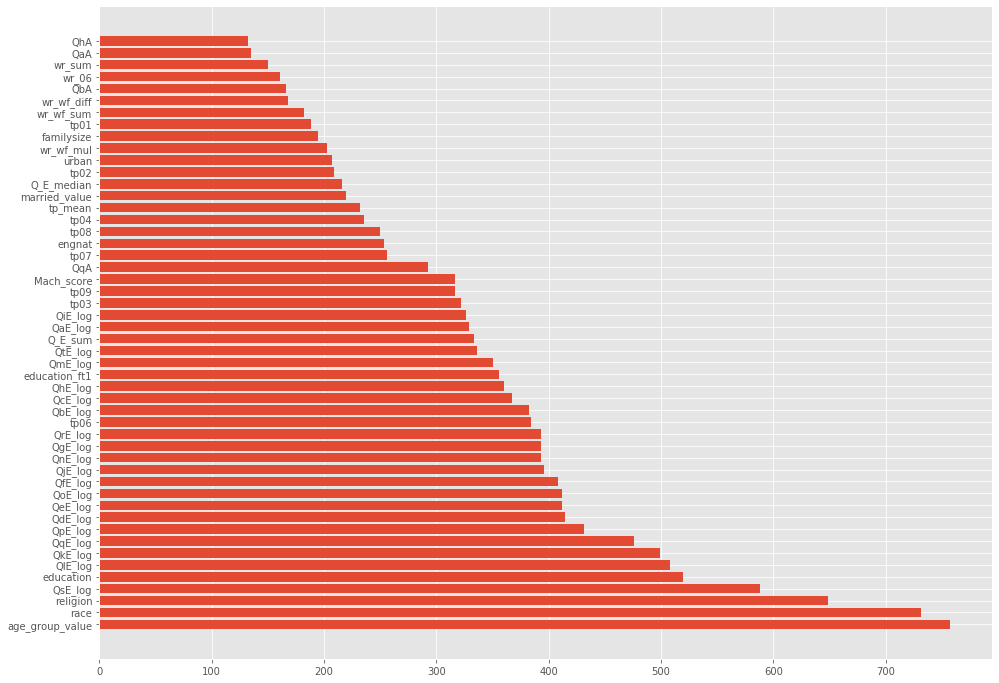

In [439]:
# 제출 35
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

[0]	validation_0-auc:0.76746	validation_1-auc:0.75729
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79402	validation_1-auc:0.76740
[200]	validation_0-auc:0.80527	validation_1-auc:0.76912
[300]	validation_0-auc:0.81428	validation_1-auc:0.77028
[400]	validation_0-auc:0.82320	validation_1-auc:0.77070
[500]	validation_0-auc:0.83315	validation_1-auc:0.77074
[600]	validation_0-auc:0.84057	validation_1-auc:0.77025
[700]	validation_0-auc:0.84694	validation_1-auc:0.76966
Stopping. Best iteration:
[437]	validation_0-auc:0.82738	validation_1-auc:0.77091

[0]	validation_0-auc:0.76970	validation_1-auc:0.75086
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79323	validation_1-auc:0.76462
[200]	validation_0-auc:0.80395	validation_1-a

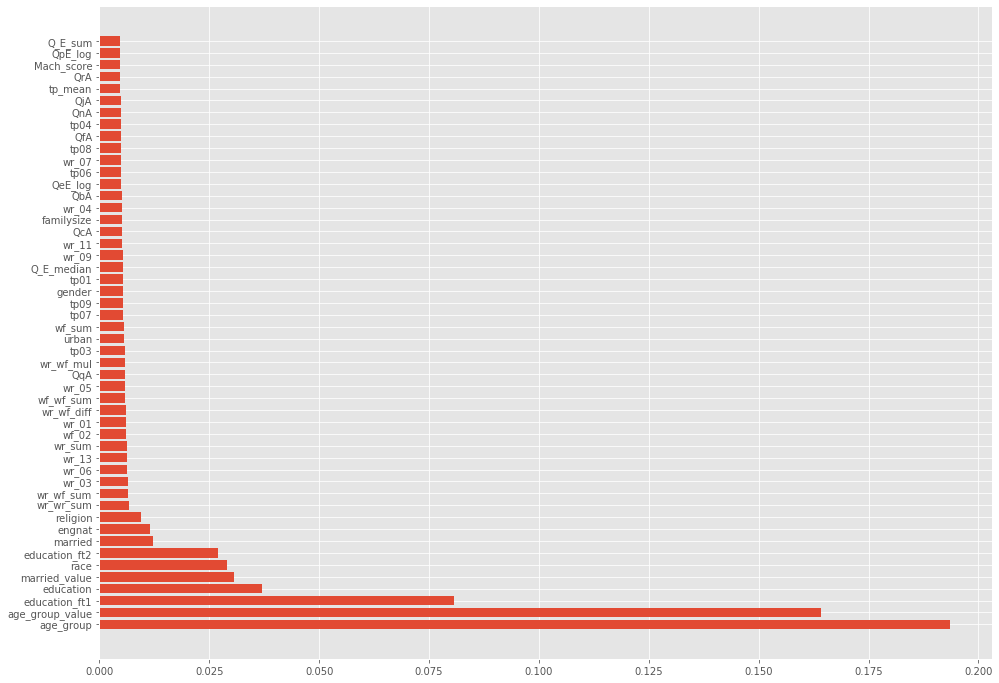

In [440]:
# 제출 35
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'xgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779081	training's binary_logloss: 0.575461	valid_1's auc: 0.76752	valid_1's binary_logloss: 0.57994
[200]	training's auc: 0.786506	training's binary_logloss: 0.550498	valid_1's auc: 0.769602	valid_1's binary_logloss: 0.560728
[300]	training's auc: 0.794327	training's binary_logloss: 0.539904	valid_1's auc: 0.770066	valid_1's binary_logloss: 0.556485
[400]	training's auc: 0.804165	training's binary_logloss: 0.531445	valid_1's auc: 0.770652	valid_1's binary_logloss: 0.55524
[500]	training's auc: 0.813702	training's binary_logloss: 0.523856	valid_1's auc: 0.771034	valid_1's binary_logloss: 0.554761
[600]	training's auc: 0.820748	training's binary_logloss: 0.518158	valid_1's auc: 0.77124	valid_1's binary_logloss: 0.554517
[700]	training's auc: 0.826899	training's binary_logloss: 0.513034	valid_1's auc: 0.770869	valid_1's binary_logloss: 0.55474
[800]	training's auc: 0.83366	training's binary_logloss: 0.50

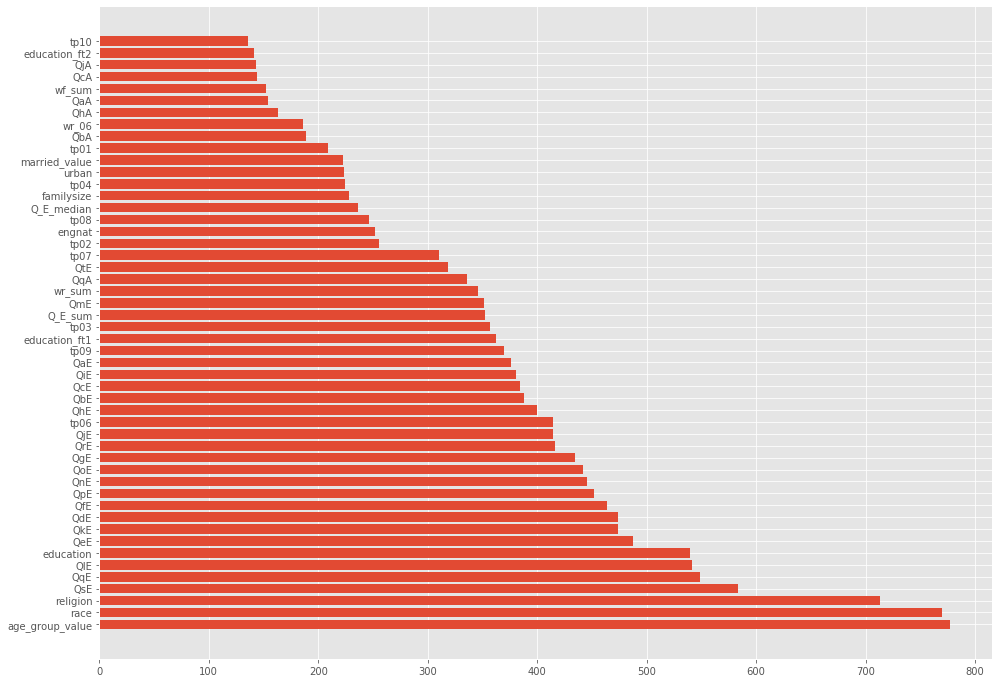

In [446]:
# 제출 36
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.781578	training's binary_logloss: 0.573732	valid_1's auc: 0.769295	valid_1's binary_logloss: 0.581234
[200]	training's auc: 0.788952	training's binary_logloss: 0.548359	valid_1's auc: 0.770076	valid_1's binary_logloss: 0.562037
[300]	training's auc: 0.79604	training's binary_logloss: 0.538258	valid_1's auc: 0.771209	valid_1's binary_logloss: 0.557107
[400]	training's auc: 0.805648	training's binary_logloss: 0.529951	valid_1's auc: 0.771779	valid_1's binary_logloss: 0.555574
[500]	training's auc: 0.813994	training's binary_logloss: 0.523044	valid_1's auc: 0.772224	valid_1's binary_logloss: 0.554853
[600]	training's auc: 0.821549	training's binary_logloss: 0.516981	valid_1's auc: 0.772372	valid_1's binary_logloss: 0.554537
[700]	training's auc: 0.82834	training's binary_logloss: 0.511408	valid_1's auc: 0.772256	valid_1's binary_logloss: 0.554454
[800]	training's auc: 0.834511	training's binary_logloss: 

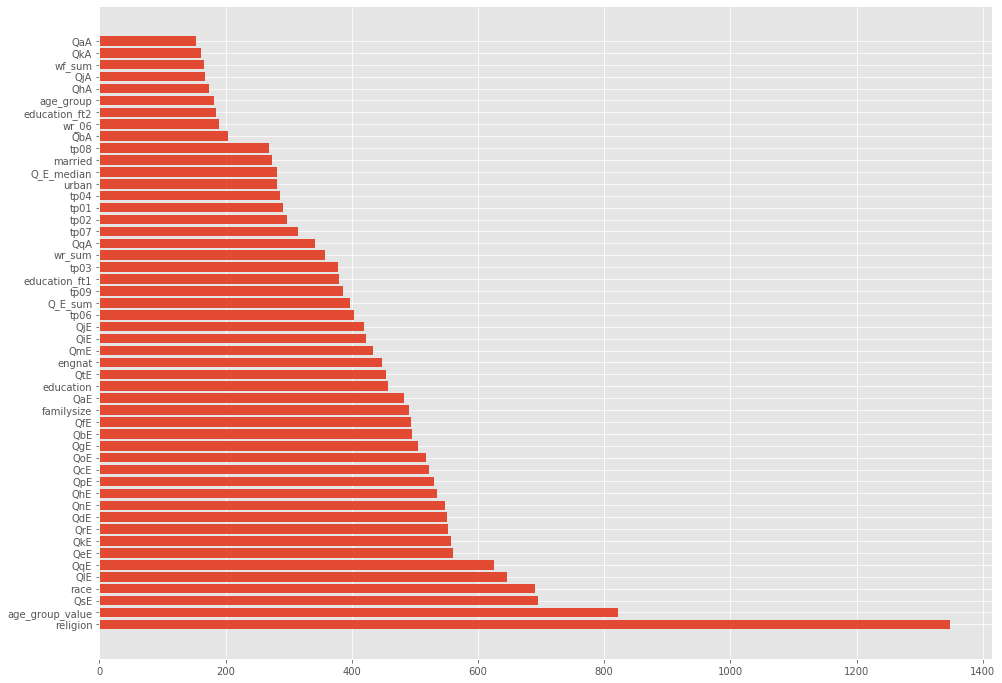

In [564]:
# 제출 37
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.778886	training's binary_logloss: 0.575507	valid_1's auc: 0.765592	valid_1's binary_logloss: 0.579926
[200]	training's auc: 0.786788	training's binary_logloss: 0.550416	valid_1's auc: 0.76874	valid_1's binary_logloss: 0.56006
[300]	training's auc: 0.794153	training's binary_logloss: 0.540265	valid_1's auc: 0.769931	valid_1's binary_logloss: 0.555693
[400]	training's auc: 0.804017	training's binary_logloss: 0.531698	valid_1's auc: 0.770563	valid_1's binary_logloss: 0.554484
[500]	training's auc: 0.813113	training's binary_logloss: 0.524351	valid_1's auc: 0.770907	valid_1's binary_logloss: 0.554149
[600]	training's auc: 0.820116	training's binary_logloss: 0.518592	valid_1's auc: 0.770995	valid_1's binary_logloss: 0.554009
[700]	training's auc: 0.827381	training's binary_logloss: 0.512672	valid_1's auc: 0.771198	valid_1's binary_logloss: 0.553881
[800]	training's auc: 0.833709	training's binary_logloss: 

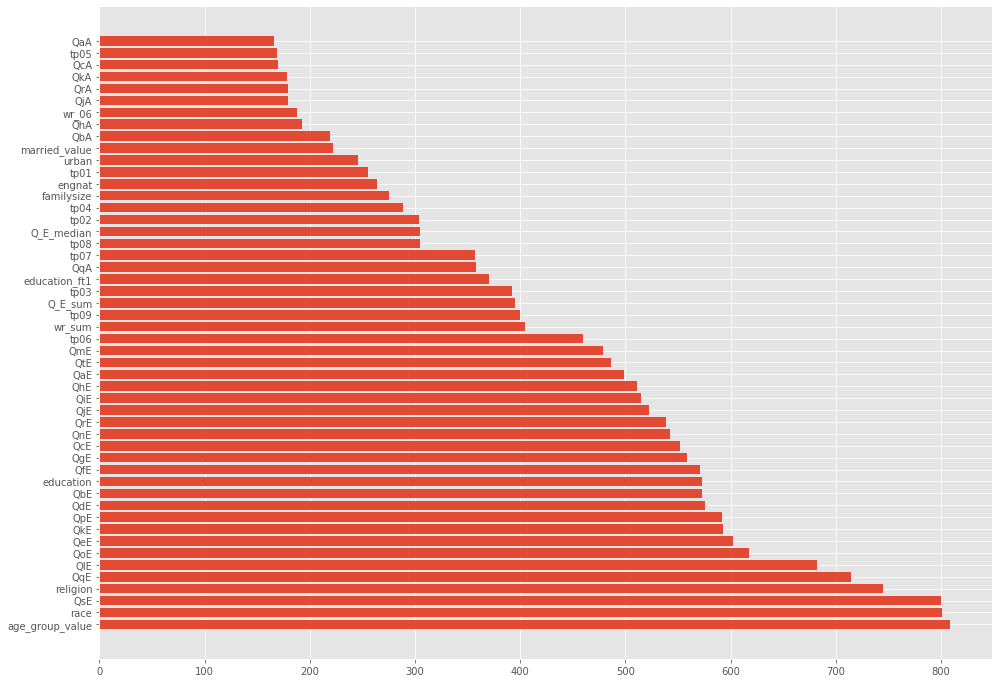

In [571]:
# 제출 38
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.779013	training's binary_logloss: 0.575313	valid_1's auc: 0.765519	valid_1's binary_logloss: 0.58044
[200]	training's auc: 0.787582	training's binary_logloss: 0.550232	valid_1's auc: 0.767317	valid_1's binary_logloss: 0.561092
[300]	training's auc: 0.795791	training's binary_logloss: 0.539633	valid_1's auc: 0.768594	valid_1's binary_logloss: 0.556217
[400]	training's auc: 0.805972	training's binary_logloss: 0.530976	valid_1's auc: 0.768493	valid_1's binary_logloss: 0.555173
[500]	training's auc: 0.81415	training's binary_logloss: 0.524072	valid_1's auc: 0.768713	valid_1's binary_logloss: 0.554714
[600]	training's auc: 0.821059	training's binary_logloss: 0.518349	valid_1's auc: 0.768389	valid_1's binary_logloss: 0.554836
[700]	training's auc: 0.828059	training's binary_logloss: 0.512437	valid_1's auc: 0.76792	valid_1's binary_logloss: 0.555069
Early stopping, best iteration is:
[479]	training's auc: 0.

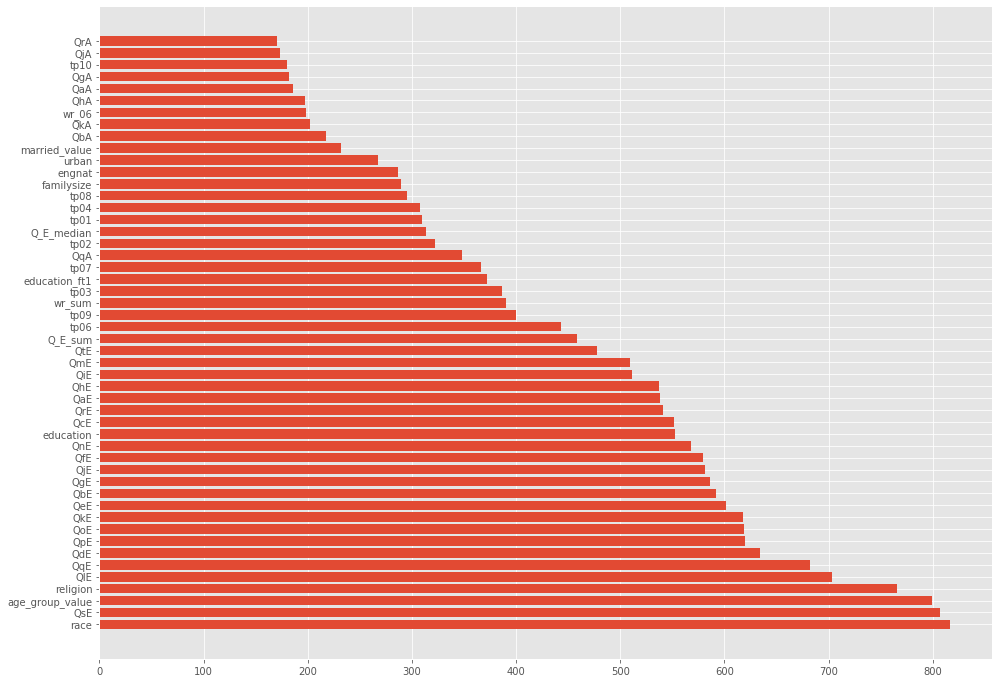

In [576]:
# 제출 39
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.778105	training's binary_logloss: 0.583425	valid_1's auc: 0.760275	valid_1's binary_logloss: 0.59133
[200]	training's auc: 0.785739	training's binary_logloss: 0.554923	valid_1's auc: 0.762716	valid_1's binary_logloss: 0.568965
[300]	training's auc: 0.791203	training's binary_logloss: 0.543575	valid_1's auc: 0.764228	valid_1's binary_logloss: 0.562439
[400]	training's auc: 0.797453	training's binary_logloss: 0.536534	valid_1's auc: 0.765124	valid_1's binary_logloss: 0.560279
[500]	training's auc: 0.805952	training's binary_logloss: 0.529588	valid_1's auc: 0.766138	valid_1's binary_logloss: 0.559168
[600]	training's auc: 0.813513	training's binary_logloss: 0.523673	valid_1's auc: 0.76626	valid_1's binary_logloss: 0.558841
[700]	training's auc: 0.81977	training's binary_logloss: 0.518601	valid_1's auc: 0.766454	valid_1's binary_logloss: 0.55874
[800]	training's auc: 0.825688	training's binary_logloss: 0.

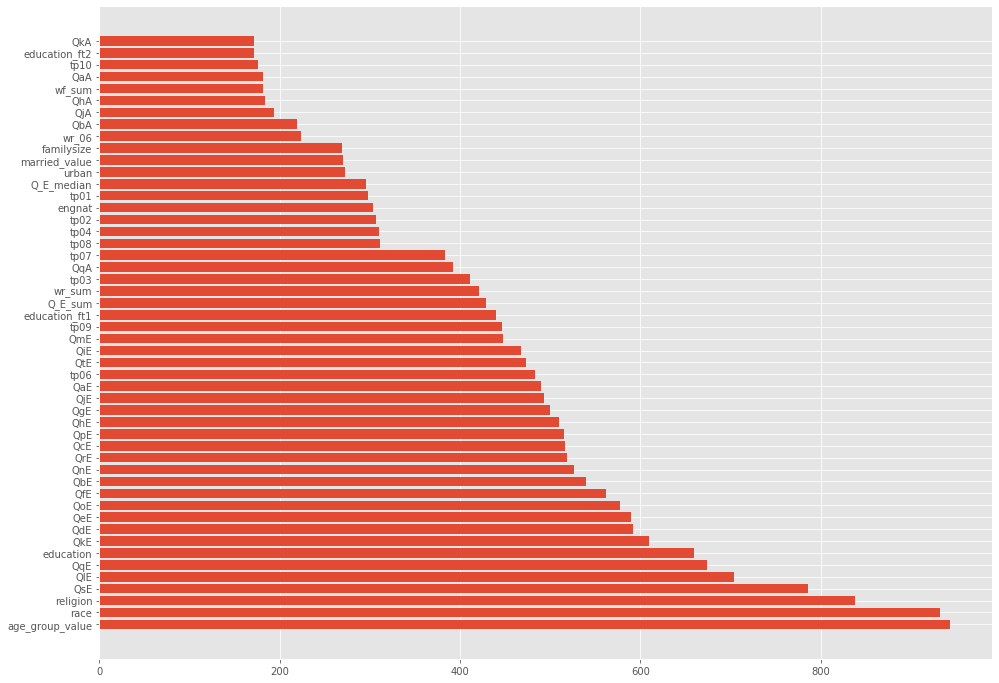

In [586]:
# 제출 40
ft_df_lgb, test_preds_lgb = test_inference(tr,te,'lgb')

[0]	validation_0-auc:0.76769	validation_1-auc:0.76046
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79238	validation_1-auc:0.77347
[200]	validation_0-auc:0.80348	validation_1-auc:0.77537
[300]	validation_0-auc:0.81343	validation_1-auc:0.77615
[400]	validation_0-auc:0.82361	validation_1-auc:0.77581
[500]	validation_0-auc:0.83147	validation_1-auc:0.77622
[600]	validation_0-auc:0.83858	validation_1-auc:0.77616
[700]	validation_0-auc:0.84584	validation_1-auc:0.77623
Stopping. Best iteration:
[482]	validation_0-auc:0.83022	validation_1-auc:0.77627

[0]	validation_0-auc:0.77252	validation_1-auc:0.75396
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.79317	validation_1-auc:0.76433
[200]	validation_0-auc:0.80321	validation_1-a

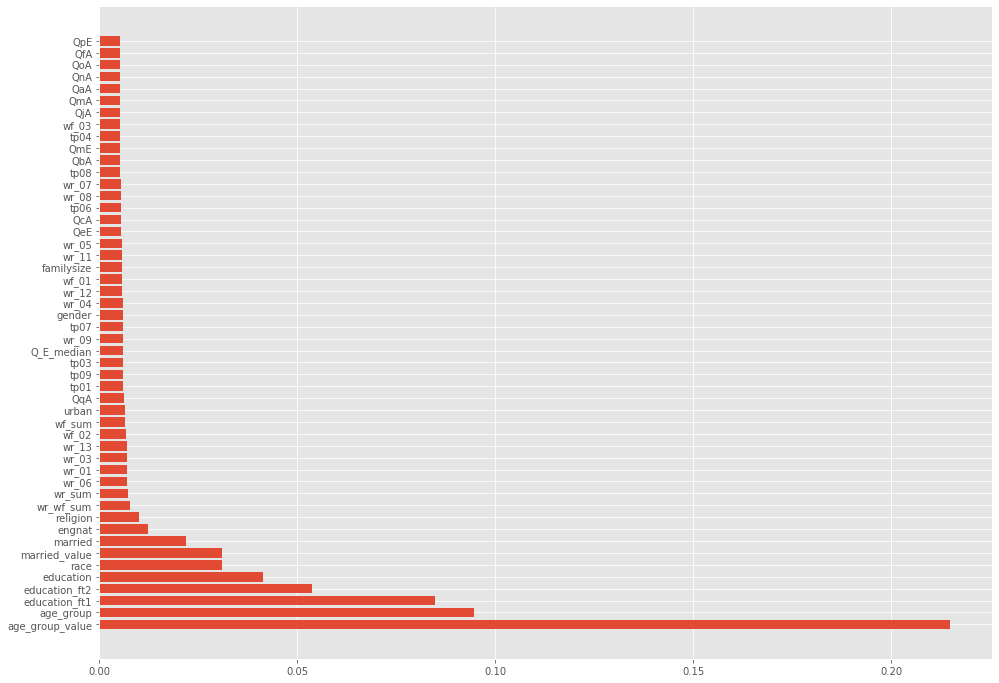

In [587]:
# 제출 40
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'xgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.802613	training's binary_logloss: 0.59864	valid_1's auc: 0.760006	valid_1's binary_logloss: 0.610087
[200]	training's auc: 0.813001	training's binary_logloss: 0.558328	valid_1's auc: 0.761876	valid_1's binary_logloss: 0.58026
[300]	training's auc: 0.822304	training's binary_logloss: 0.536097	valid_1's auc: 0.762435	valid_1's binary_logloss: 0.567891
[400]	training's auc: 0.829407	training's binary_logloss: 0.522675	valid_1's auc: 0.763349	valid_1's binary_logloss: 0.562456
[500]	training's auc: 0.83624	training's binary_logloss: 0.513113	valid_1's auc: 0.763644	valid_1's binary_logloss: 0.560249
[600]	training's auc: 0.843896	training's binary_logloss: 0.504826	valid_1's auc: 0.763869	valid_1's binary_logloss: 0.559311
[700]	training's auc: 0.850182	training's binary_logloss: 0.498319	valid_1's auc: 0.764274	valid_1's binary_logloss: 0.558848
[800]	training's auc: 0.856753	training's binary_logloss: 0

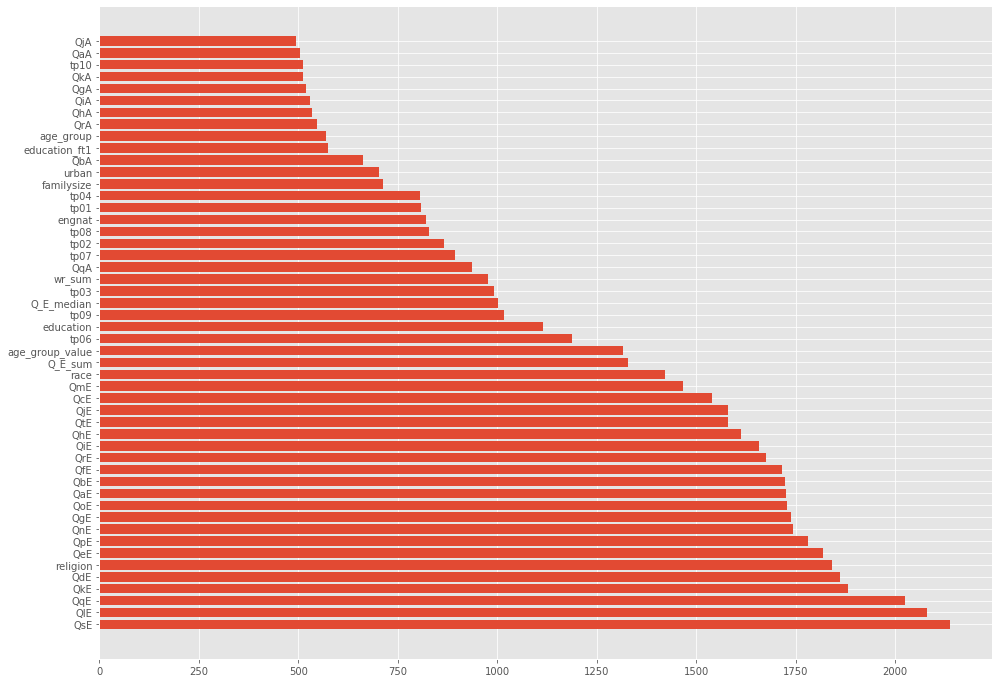

In [626]:
# 제출 41
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'lgb')

Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.805408	training's binary_logloss: 0.598432	valid_1's auc: 0.765089	valid_1's binary_logloss: 0.61001
[200]	training's auc: 0.815357	training's binary_logloss: 0.557905	valid_1's auc: 0.766543	valid_1's binary_logloss: 0.580056
[300]	training's auc: 0.824239	training's binary_logloss: 0.535778	valid_1's auc: 0.766869	valid_1's binary_logloss: 0.567654
[400]	training's auc: 0.831351	training's binary_logloss: 0.522286	valid_1's auc: 0.768034	valid_1's binary_logloss: 0.561981
[500]	training's auc: 0.838327	training's binary_logloss: 0.51261	valid_1's auc: 0.768363	valid_1's binary_logloss: 0.559675
[600]	training's auc: 0.845526	training's binary_logloss: 0.504499	valid_1's auc: 0.768481	valid_1's binary_logloss: 0.558652
[700]	training's auc: 0.852396	training's binary_logloss: 0.497601	valid_1's auc: 0.76848	valid_1's binary_logloss: 0.558388
[800]	training's auc: 0.858566	training's binary_logloss: 0

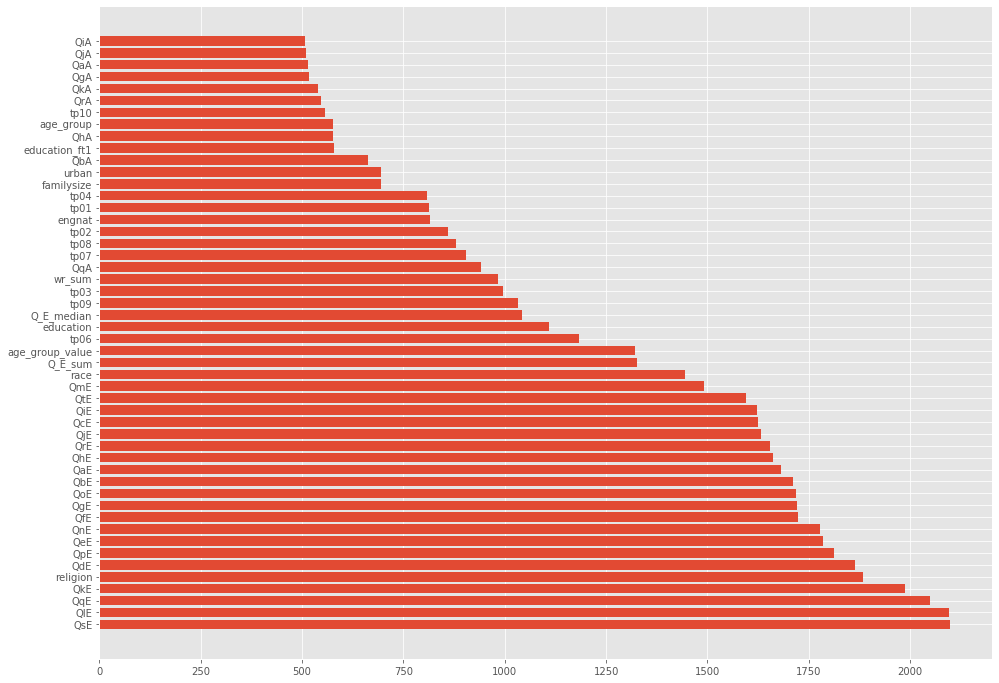

In [633]:
# 제출 42
ft_df_xgb, test_preds_xgb = test_inference(tr,te,'lgb')

# Create Submission

In [588]:
test_preds = (test_preds_lgb * 0.6) + (test_preds_xgb * 0.4)

In [630]:
#submission['voted'] = test_preds
submission['voted'] = test_preds_xgb

In [631]:
n_sub = 41

In [632]:
submission.to_csv(
    os.path.join(data_file_path,'dacon_submission{}.csv'.format(n_sub)
            ),index = False)

In [ ]:
# 28: xgb + lgb 앙상블 -> 0.78029
# 30: 기존 성능이 가장 좋았던 wf_wr_sum까지 한 뒤 kfold rs없이 제출 - index 포험 -> 0.78072
# 31: 마찬가지로 rs없이 제출 - index 포함x -> 0.78038
# 32: 0.78054 -> qe 데이터 로그화
# 33: -> 0.7788.... tp, wr 클러스터링 변수 생성 개떡락
# 34: -> ver9 데이터에 objective=dart로 변환
# 37: object 컬럼 카테고리컬 컬럼으로 변경해서 시행
# 38: colsample 0.70
